## **HOUSE PRICE PREDICTION**

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.optimize import curve_fit
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
from sklearn.impute import KNNImputer
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import shap

# **EDA**

# we start by discovering our data and its features

In [87]:
file_path = 'data.xlsx'
data = pd.read_excel(file_path)

In [88]:
data.shape

(1460, 81)

In [89]:
data.head()

id  sub_ms_class zoning_ms  frontge_lot  area_lot streetname alleyname  \
0   128            45        RM         55.0      4388       Pave       NaN   
1   456            20        RL         80.0      9600       Pave       NaN   
2  1324            30        RL         50.0      5330       Pave       NaN   
3   218            70        RM         57.0      9906       Pave      Grvl   
4  1182           120        RM         64.0      5587       Pave       NaN   

  shape_lot contour_land    util  ... poolarea poolqc fence miscfeature  \
0       IR1          Bnk  AllPub  ...        0    NaN   NaN         NaN   
1       Reg          Lvl  AllPub  ...        0    NaN   NaN         NaN   
2       Reg          HLS  AllPub  ...        0    NaN   NaN         NaN   
3       Reg          Lvl  AllPub  ...        0    NaN   NaN         NaN   
4       IR1          HLS  AllPub  ...        0    NaN   NaN         NaN   

  miscval mosold yrsold  saletype  salecondition  saleprice  
0       0      6   2007        WD         Normal      87000  
1       0      9   2007        WD         Normal     175500  
2       0     12   2009        WD         Normal      82500  
3       0      9   2006        WD         Family     107000  
4       0     11   2008       New        Partial     392500  

[5 rows x 81 columns]

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1460 non-null   int64  
 1   sub_ms_class      1460 non-null   int64  
 2   zoning_ms         1460 non-null   object 
 3   frontge_lot       1201 non-null   float64
 4   area_lot          1460 non-null   int64  
 5   streetname        1460 non-null   object 
 6   alleyname         91 non-null     object 
 7   shape_lot         1460 non-null   object 
 8   contour_land      1460 non-null   object 
 9   util              1460 non-null   object 
 10  configlot         1460 non-null   object 
 11  slopeland         1460 non-null   object 
 12  neighborhood      1460 non-null   object 
 13  c1                1460 non-null   object 
 14  c2                1460 non-null   object 
 15  type_building     1460 non-null   object 
 16  style_house       1460 non-null   object 


**We then plot our features types to categorize them into numerical features and categorical features**

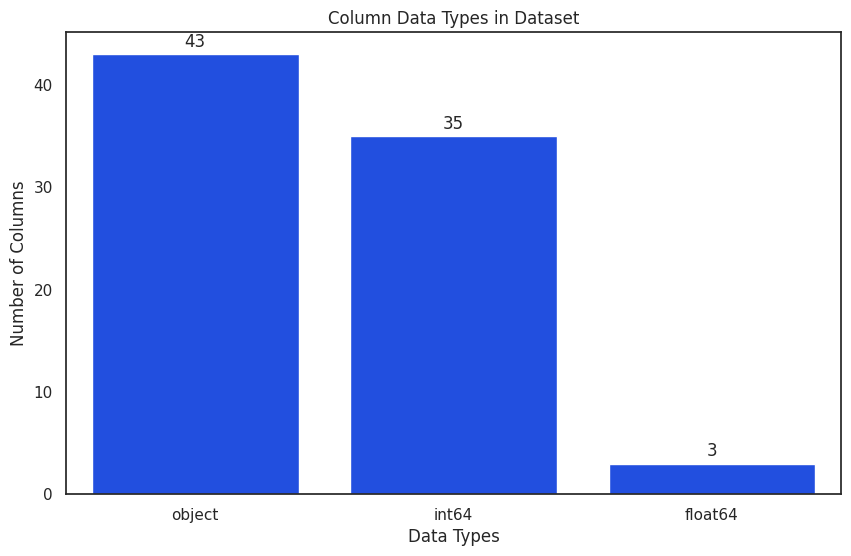

In [91]:
dtype_count = data.dtypes.value_counts()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(x=dtype_count.index.astype(str), y=dtype_count.values)
plt.xlabel('Data Types')
plt.ylabel('Number of Columns')
plt.title('Column Data Types in Dataset')

# Annotating each bar with its count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.show()

**categorize between numerical_features and categorical_features**

In [92]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns
int_features = data.select_dtypes(include=['int64']).columns
float_features = data.select_dtypes(include=['float64']).columns
numerical_features = np.concatenate([int_features, float_features])

# **Numerical features**

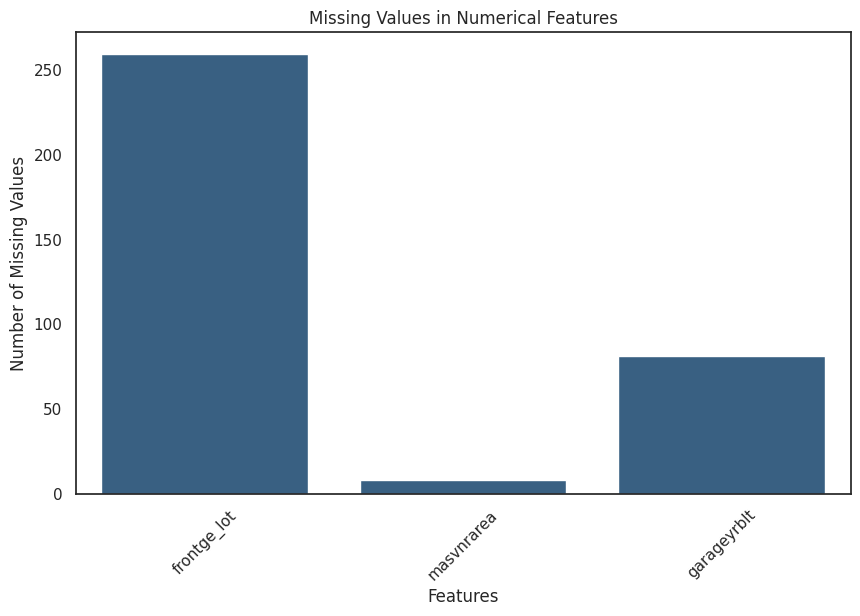

In [93]:
# Calculating missing values
missing_values = data[numerical_features].isnull().sum()

# Filter out columns that have no missing values to declutter the plot
missing_values = missing_values[missing_values > 0]

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values, color='#2d618e')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Numerical Features')
plt.xticks(rotation=45)
plt.show()

**it seems that we have some missing values for the numerical features frontge_lot , masvnrarea and garageyrblt
and since we're working on regression its better to impute them with KNN**

In [94]:
# Extracting the numerical data for imputation
numerical_data = data[numerical_features]

# Creating the KNN imputer instance
# You can choose n_neighbors (e.g., 5) as per your requirement
knn_imputer = KNNImputer(n_neighbors=5)

# Fitting the imputer and transforming the numerical data
imputed_numerical_data = knn_imputer.fit_transform(numerical_data)

# Converting imputed data back to a DataFrame
imputed_numerical_data = pd.DataFrame(imputed_numerical_data, columns=numerical_features)

# Updating the numerical_data with imputed values
numerical_data = imputed_numerical_data

# Optionally, update these imputed values back to the original 'data' DataFrame
# if you want to maintain a single consolidated DataFrame
data[numerical_features] = numerical_data

# Target feature Saleprice

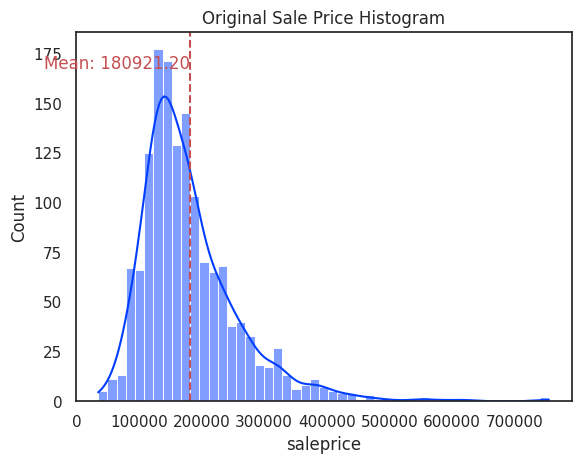

In [95]:
sns.histplot(data['saleprice'], kde=True)
mean_value = data['saleprice'].mean()
plt.axvline(mean_value, color='r', linestyle='--')
plt.text(mean_value, plt.ylim()[1]*0.9, f'Mean: {mean_value:.2f}', color = 'r', ha='right')
plt.title('Original Sale Price Histogram')
plt.show()

**The skewness was about 1.88. Also, since the metric is RMSLE, we will perform log scaling.
Logarithm function increases the spacing between small numbers and reduces the spacing between large numbers. When certain features are dense with values in small values, by increasing these intervals, our models increase the intervals for small values, and we can improve the performance of the model when training and testing using these values**

# Now for continous features

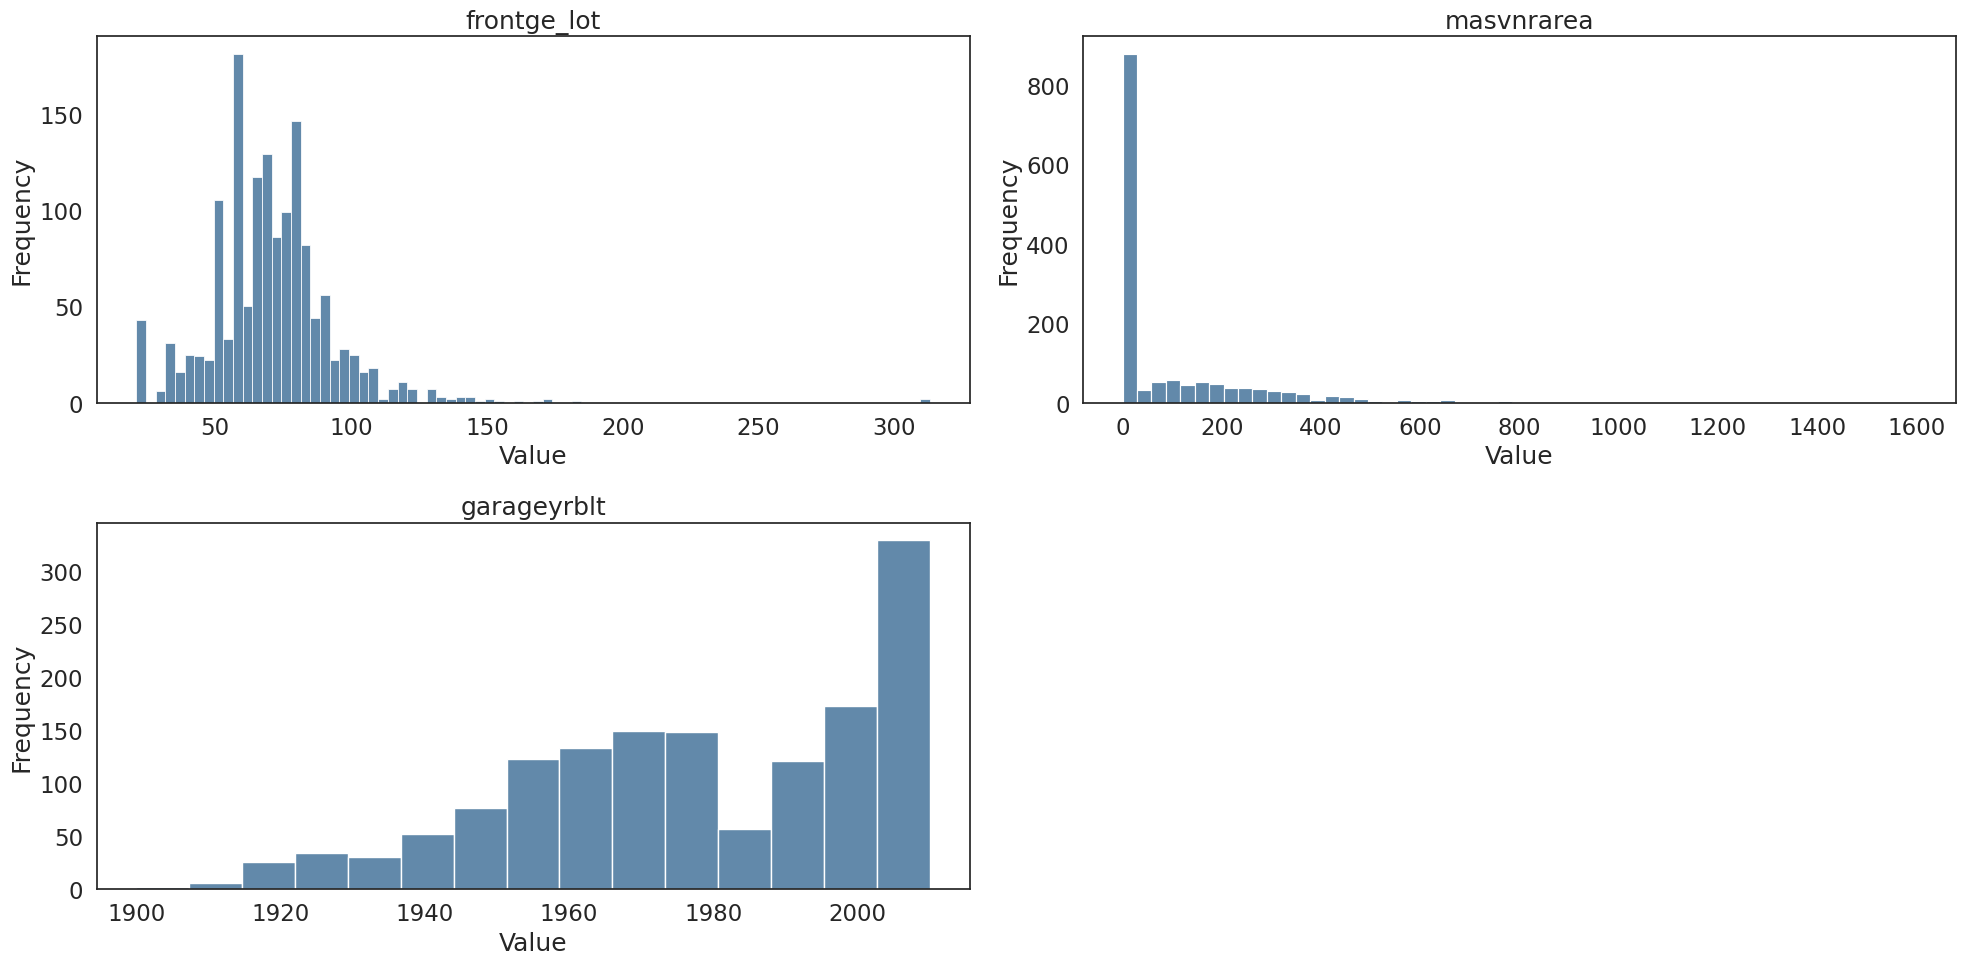

In [96]:
# Set the style
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_palette("bright")

# Determine the number of rows needed for subplots
num_features = len(float_features)
num_rows = (num_features // 2) + (num_features % 2)

# Create a figure with subplots
plt.figure(figsize=(20, 5 * num_rows))

# Loop through each float feature and create a subplot
for i, feature in enumerate(float_features, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(data[feature], kde=False, color='#2d618e')
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**It seems that there are outliers that deviate from the regression line. Let's check some more.**

# Discrete features

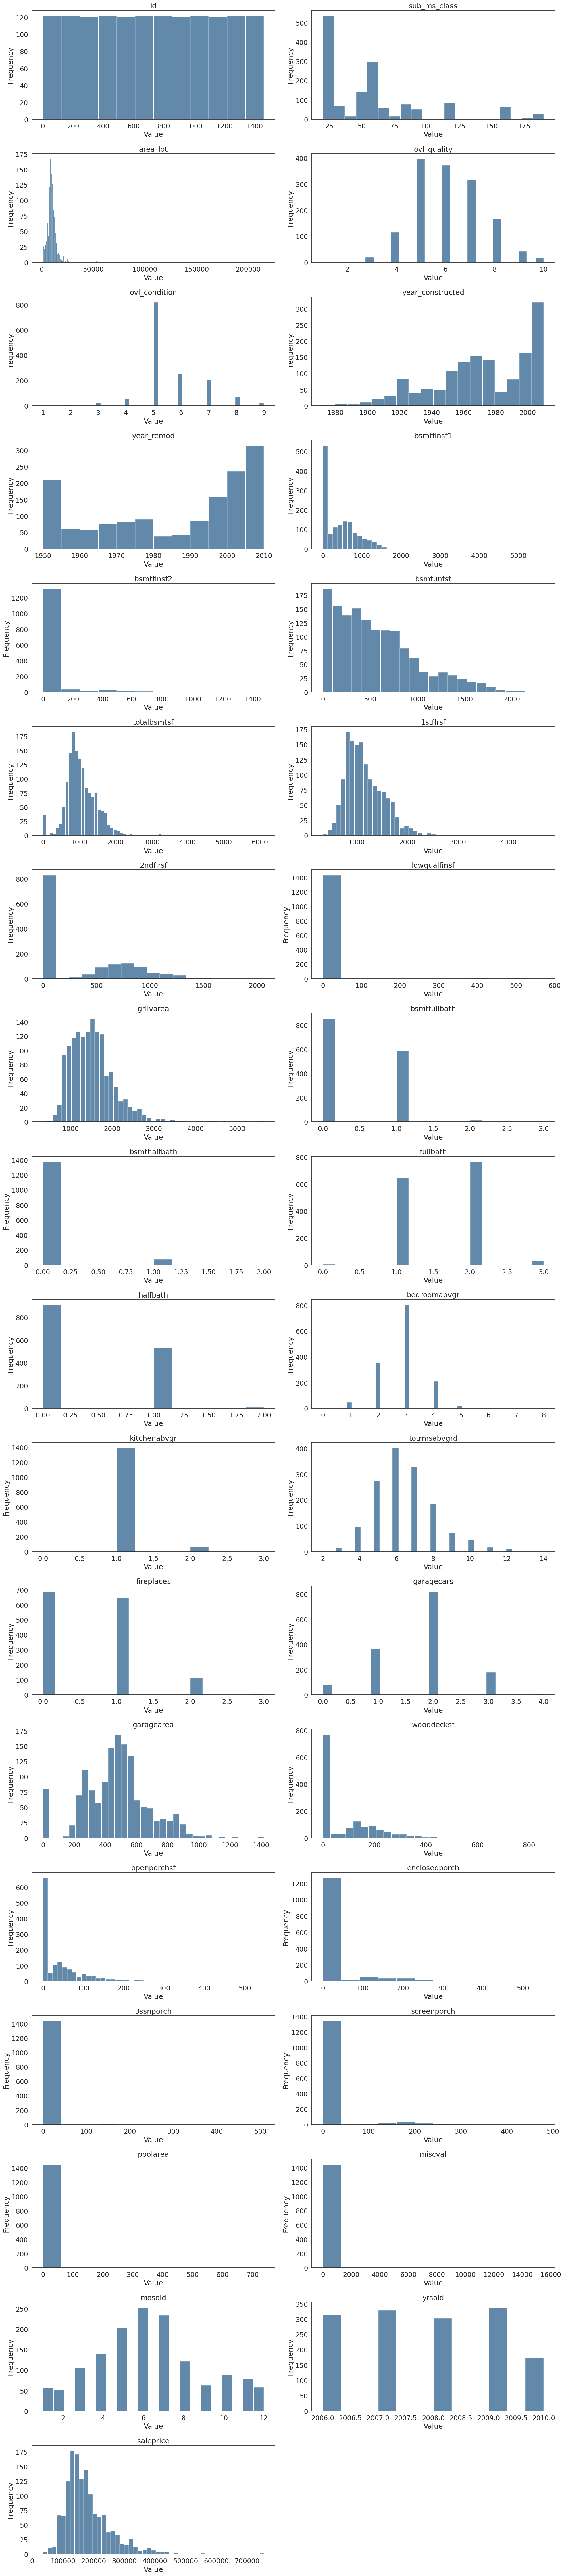

In [97]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_palette("bright")

# Determine the number of rows needed for subplots
num_features = len(int_features)
num_rows = (num_features // 2) + (num_features % 2)

# Create a figure with subplots
plt.figure(figsize=(20, 5 * num_rows))

# Loop through each int feature and create a subplot
for i, feature in enumerate(int_features, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(data[feature], kde=False, color='#2d618e')
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Some features have a skewed shape to one side.

**for sub_ms_class , yrsold , mosold are categorical features so lets handle them**

In [98]:
data['sub_ms_class'] = data['sub_ms_class'].apply(str)
data['yrsold'] = data['yrsold'].astype(str)
data['mosold'] = data['mosold'].astype(str)

**Let's update the column lists again.**

In [99]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns
int_features = data.select_dtypes(include=['int64']).columns
float_features = data.select_dtypes(include=['float64']).columns
numerical_features = np.concatenate([int_features, float_features])

# Outlier

**Lets check outliers for high correlated features so it is easier to detect them with pca**

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


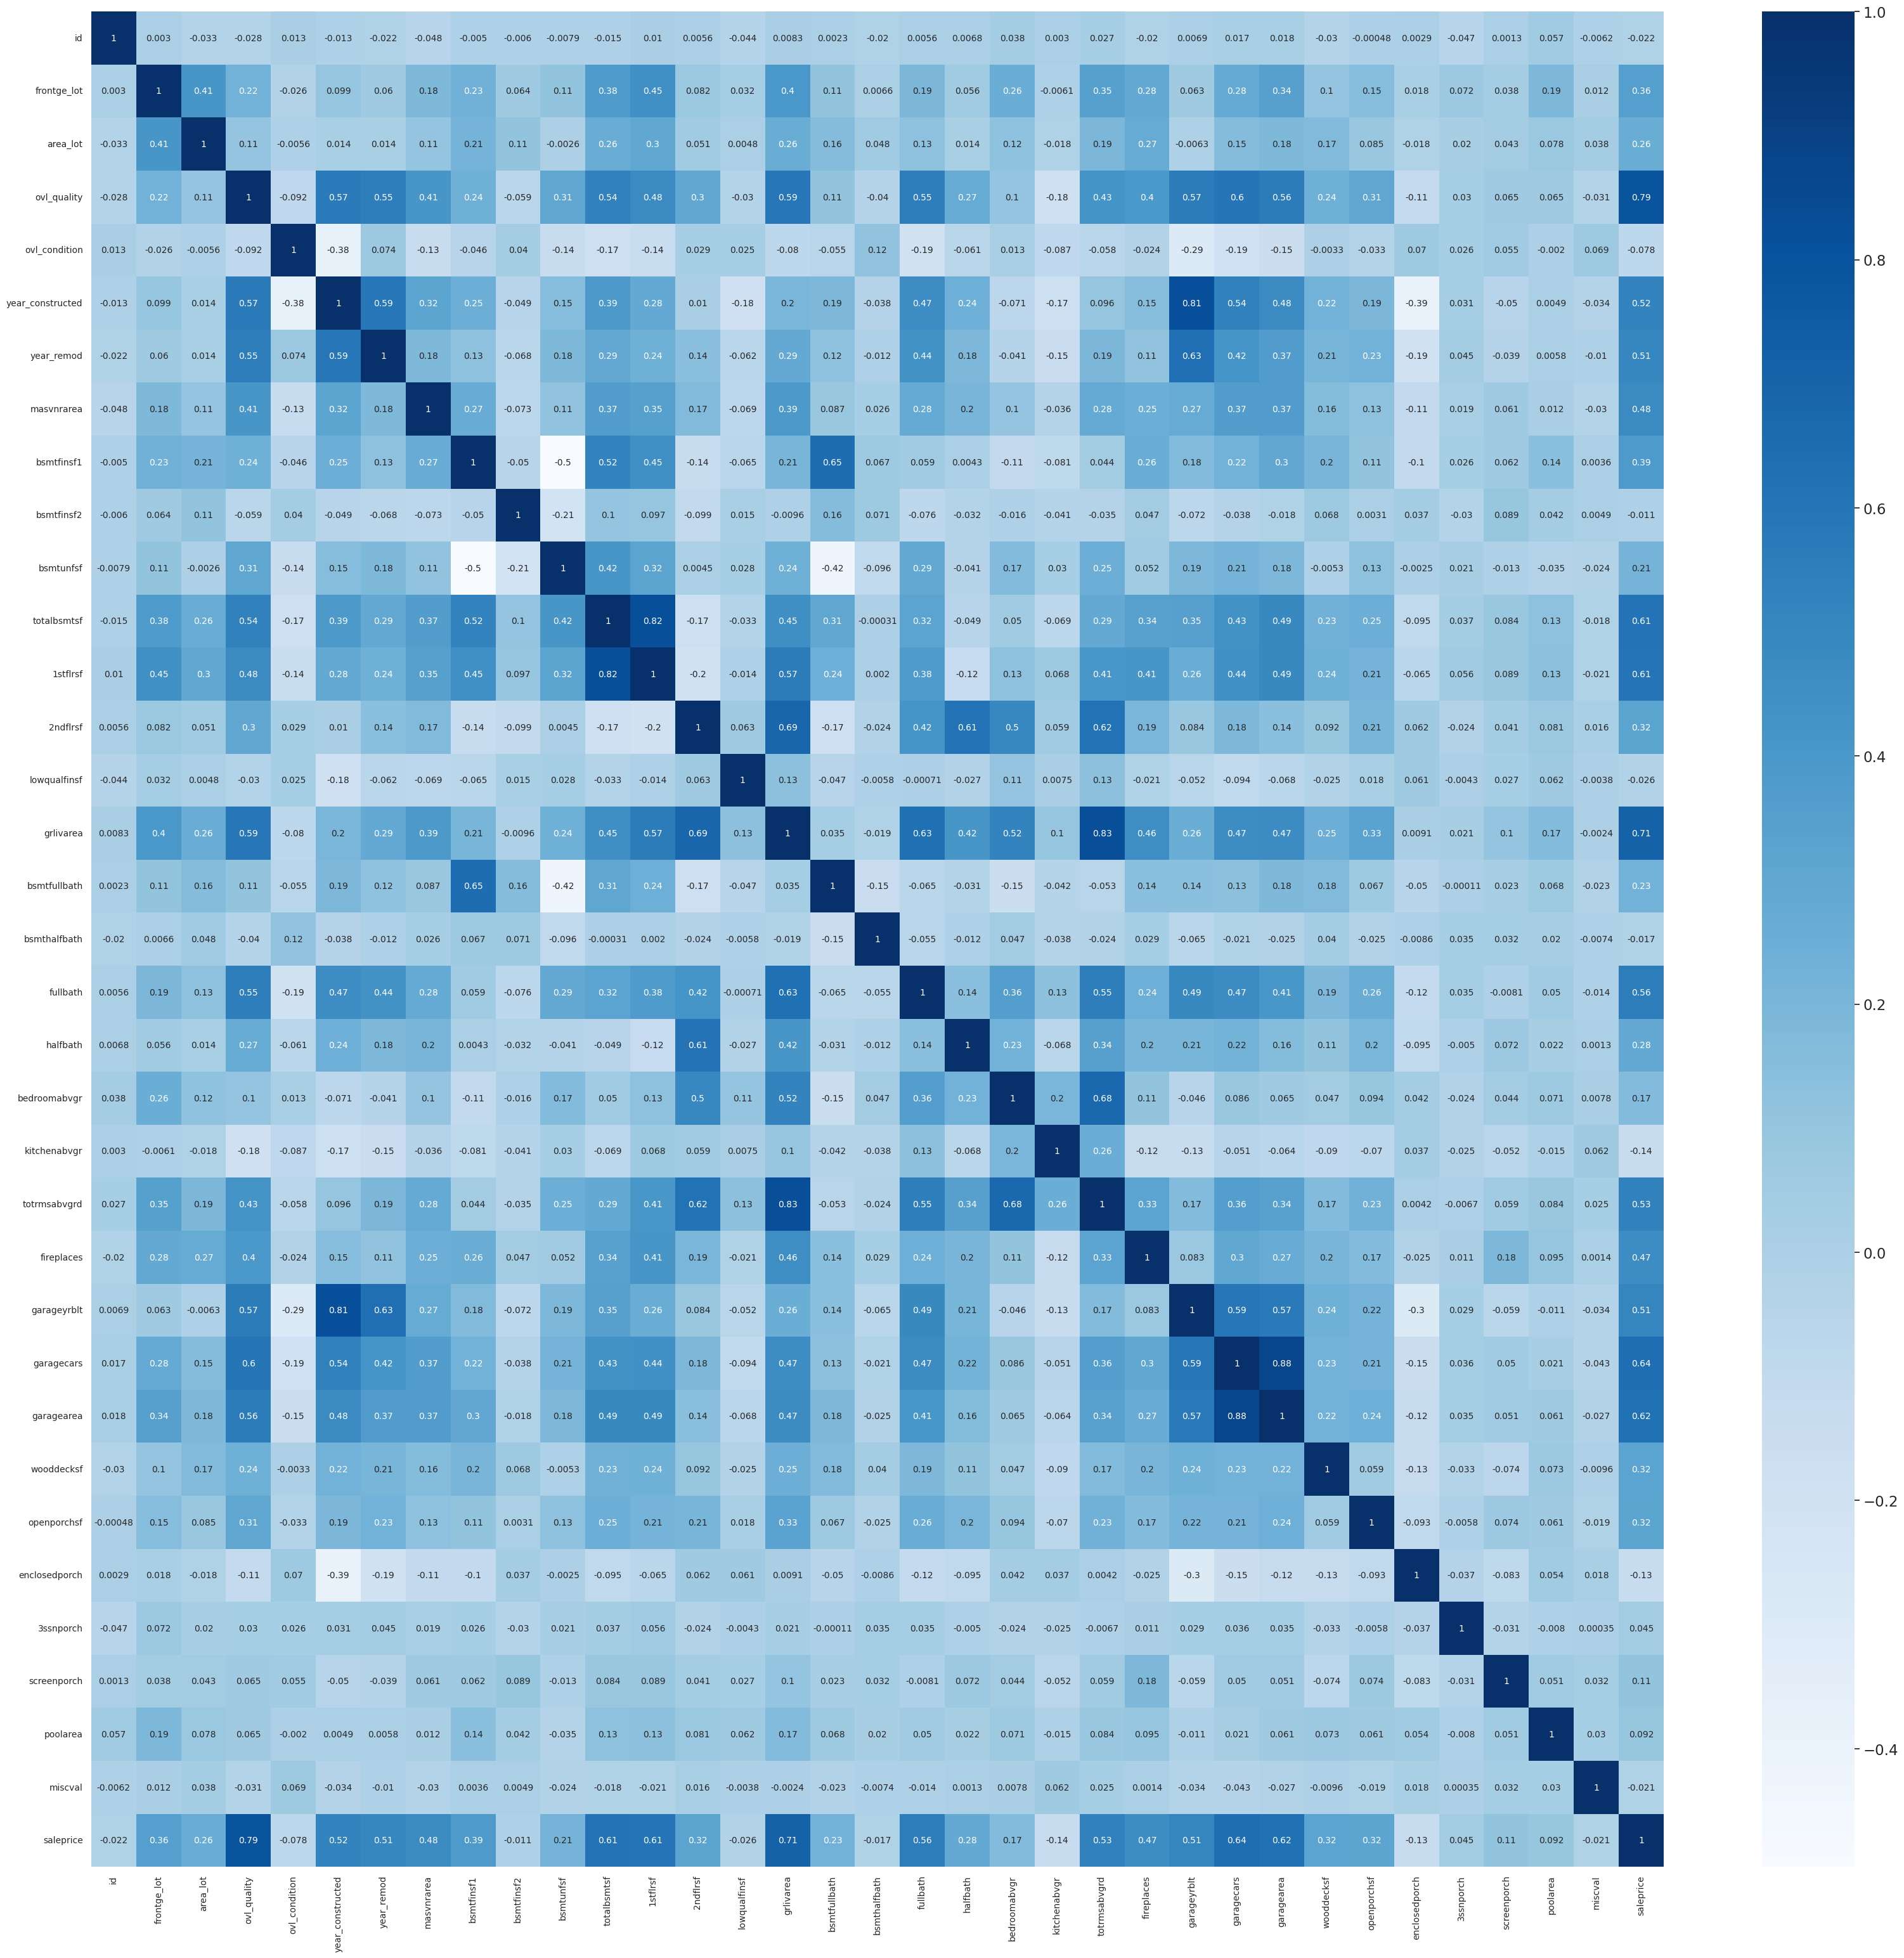

In [100]:
corr = data.corr()

# Plot correlation
plt.figure(figsize=(40, 38))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            annot_kws={'size': 10},
            cmap='Blues')  # Set the colormap to 'Blues'

# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**i'll choose 'totalbsmtsf', 'grlivarea', 'garagearea', 'ovl_quality' to detect outliers since theyre the features most correlated with saleprice**

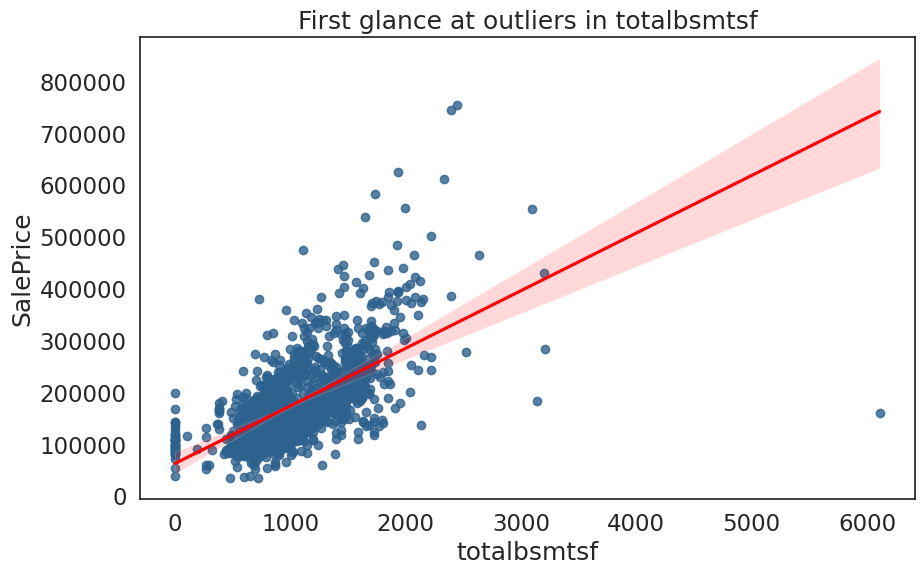

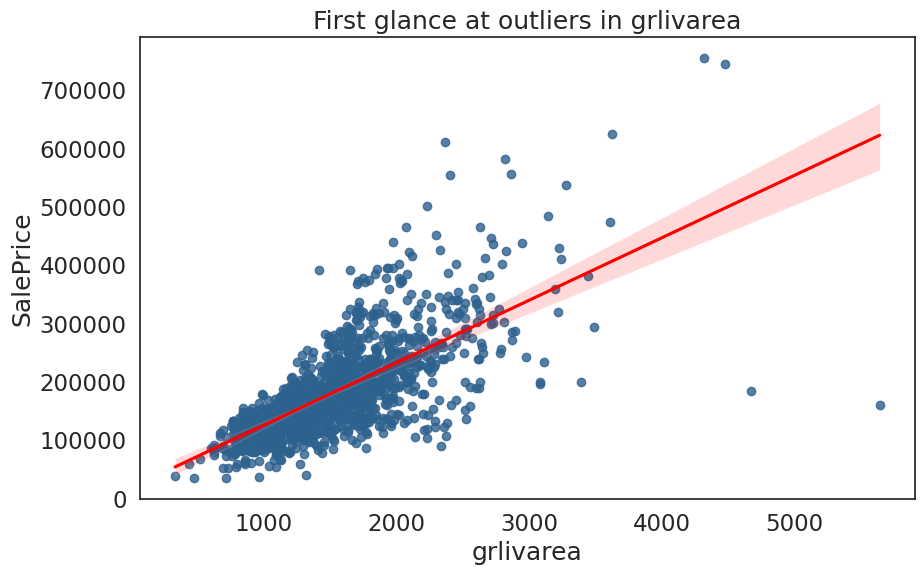

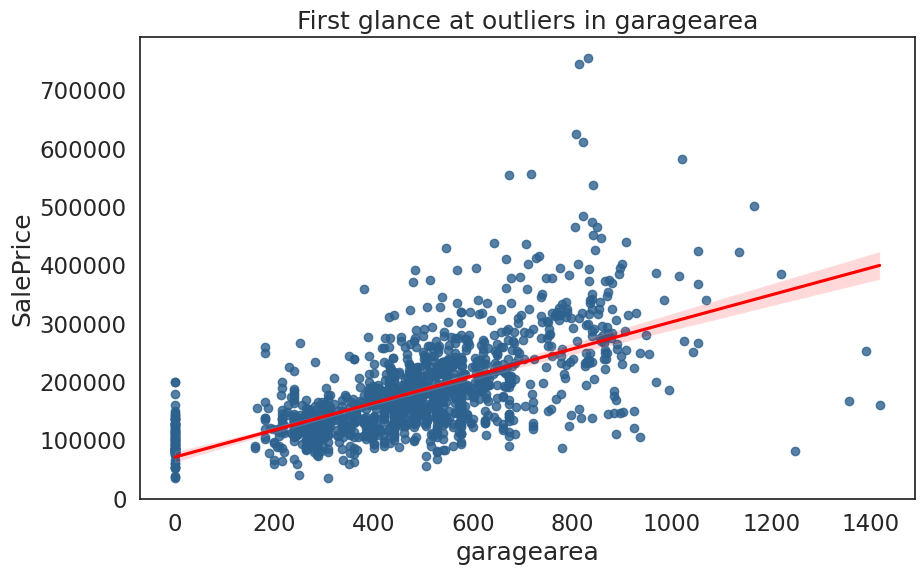

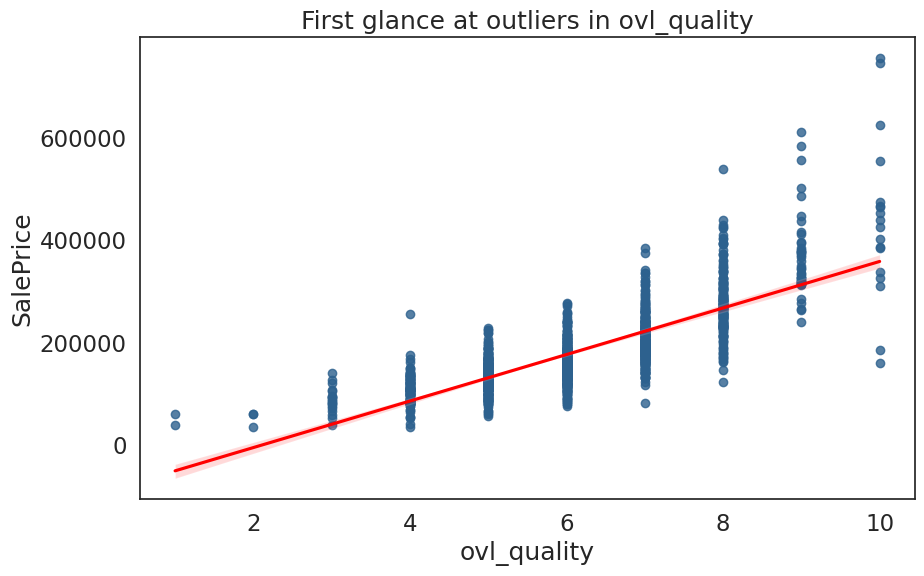

In [101]:
features = ['totalbsmtsf', 'grlivarea', 'garagearea', 'ovl_quality']
target = ['saleprice']

# Loop through each feature and create a plot
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.regplot(x=data[feature], y=data[target], line_kws={"color": "red"}, scatter_kws={"color": "#2d618e"})
    plt.title(f'First glance at outliers in {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

**looking at the results you can detect outliers. Regression models are sensitive to outliers, so it is better to remove them. Outlier is like gravity. It pulls the regression line. Therefore, it is better to remove outliers. However, it is not easy to judge an outlier. Domain knowledge may also be required to remove outliers.**

**Detecting Outliers by PCA : The more features, the higher the dimension. When projecting to a lower dimension through PCA, new insights can be gained. PCA can effectively detect outliers. Let's apply PCA to this problem and check whether the detection actually confirmed by the eye is also detected through PCA**

In [102]:
features = ['totalbsmtsf', 'grlivarea', 'garagearea', 'ovl_quality']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the features
scaled_features = scaler.fit_transform(data[features])

# Apply PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_features)

# Create a DataFrame for the transformed data
transformed_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

# Create a DataFrame to analyze components
pca_df = pd.DataFrame(data=pca.components_, columns=features, index=[f"PC{i+1}" for i in range(pca.n_components_)])

# Display the DataFrame with the PCA components
print(pca_df)

     totalbsmtsf  grlivarea  garagearea  ovl_quality
PC1     0.482071   0.492367    0.491792     0.532281
PC2     0.621855  -0.704948    0.290203    -0.179238
PC3     0.594295   0.207593   -0.776894    -0.012464
PC4     0.166485   0.466399    0.265253    -0.827282


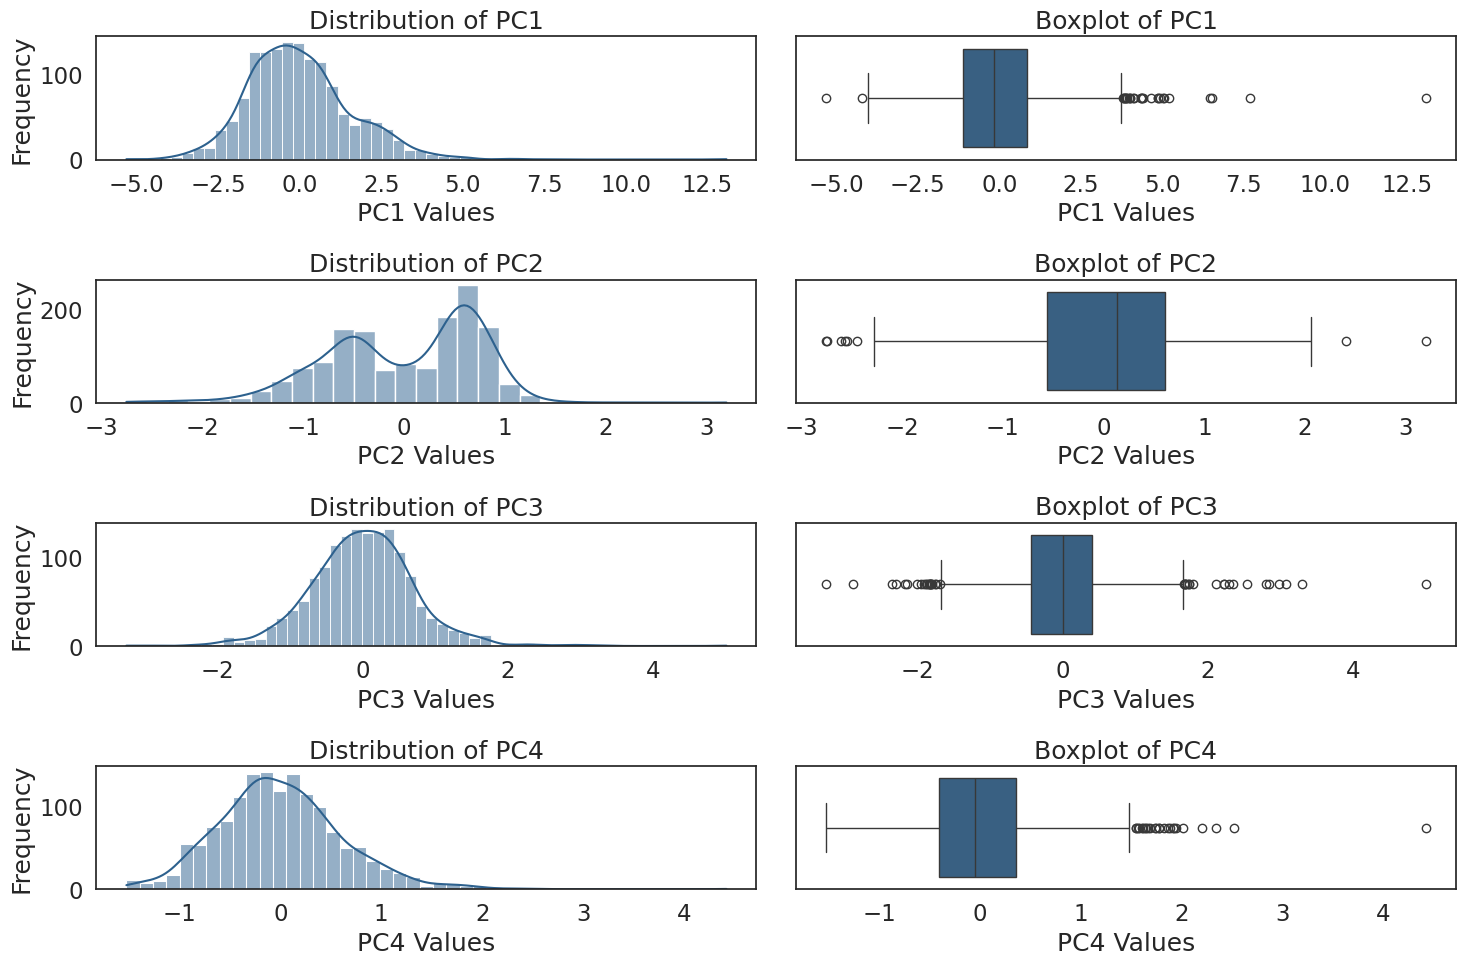

In [103]:
num_pc = transformed_df.shape[1]

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Iterate through each principal component
for i in range(num_pc):
    # Create a subplot for each principal component
    plt.subplot(num_pc, 2, 2*i+1)

    # Create the histogram for the current principal component
    sns.histplot(transformed_df.iloc[:, i], kde=True, color="#2d618e")
    plt.title(f'Distribution of PC{i+1}')
    plt.xlabel(f'PC{i+1} Values')
    plt.ylabel('Frequency')

    # Create the boxplot for the current principal component
    plt.subplot(num_pc, 2, 2*i+2)
    sns.boxplot(x=transformed_df.iloc[:, i], color="#2d618e")
    plt.title(f'Boxplot of PC{i+1}')
    plt.xlabel(f'PC{i+1} Values')

# Adjust the layout
plt.tight_layout()
plt.show()

**PC 1 has the largest variance in the dataset distribution. That is, the outlier in PC 1 is very likely to be an outlier that needs to be removed from the dataset. For this reason, there is a high possibility that an outlier to be removed is detected in PC 2 as well.**

**The order of distribution size for each PC is PC1->PC2->PC3->PC4. Since the process of finding a PC through PCA is to find a direction vector with the largest variance, this result is self-evident. Based on the boxplot, there are outliers for each PC.**

In [104]:
def outlier_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((data < lower_bound) | (data > upper_bound))[0]
# Assuming 'transformed_df' is your PCA-transformed DataFrame
pc1_outlier_idx = list(outlier_iqr(transformed_df['PC1']))
pc2_outlier_idx = list(outlier_iqr(transformed_df['PC2']))
pc3_outlier_idx = list(outlier_iqr(transformed_df['PC3']))
pc4_outlier_idx = list(outlier_iqr(transformed_df['PC4']))

# Print the indices of outliers for each principal component
print("PC1 Outlier Indices:", pc1_outlier_idx)
print("PC2 Outlier Indices:", pc2_outlier_idx)
print("PC3 Outlier Indices:", pc3_outlier_idx)
print("PC4 Outlier Indices:", pc4_outlier_idx)

PC1 Outlier Indices: [94, 140, 154, 183, 200, 329, 334, 454, 463, 491, 516, 558, 581, 707, 785, 829, 892, 910, 1060, 1117, 1123, 1128, 1219, 1235, 1372, 1384, 1417, 1454, 1455]
PC2 Outlier Indices: [250, 450, 491, 618, 706, 1237, 1372, 1455]
PC3 Outlier Indices: [19, 34, 61, 110, 120, 125, 134, 154, 155, 163, 270, 327, 426, 491, 543, 558, 578, 586, 596, 618, 639, 733, 803, 808, 832, 844, 1018, 1048, 1082, 1089, 1117, 1182, 1219, 1228, 1292, 1341, 1368, 1375, 1417, 1426, 1444]
PC4 Outlier Indices: [65, 66, 130, 135, 158, 232, 386, 458, 491, 502, 558, 580, 596, 715, 803, 906, 942, 1013, 1138, 1155, 1215, 1258, 1292, 1437, 1444]


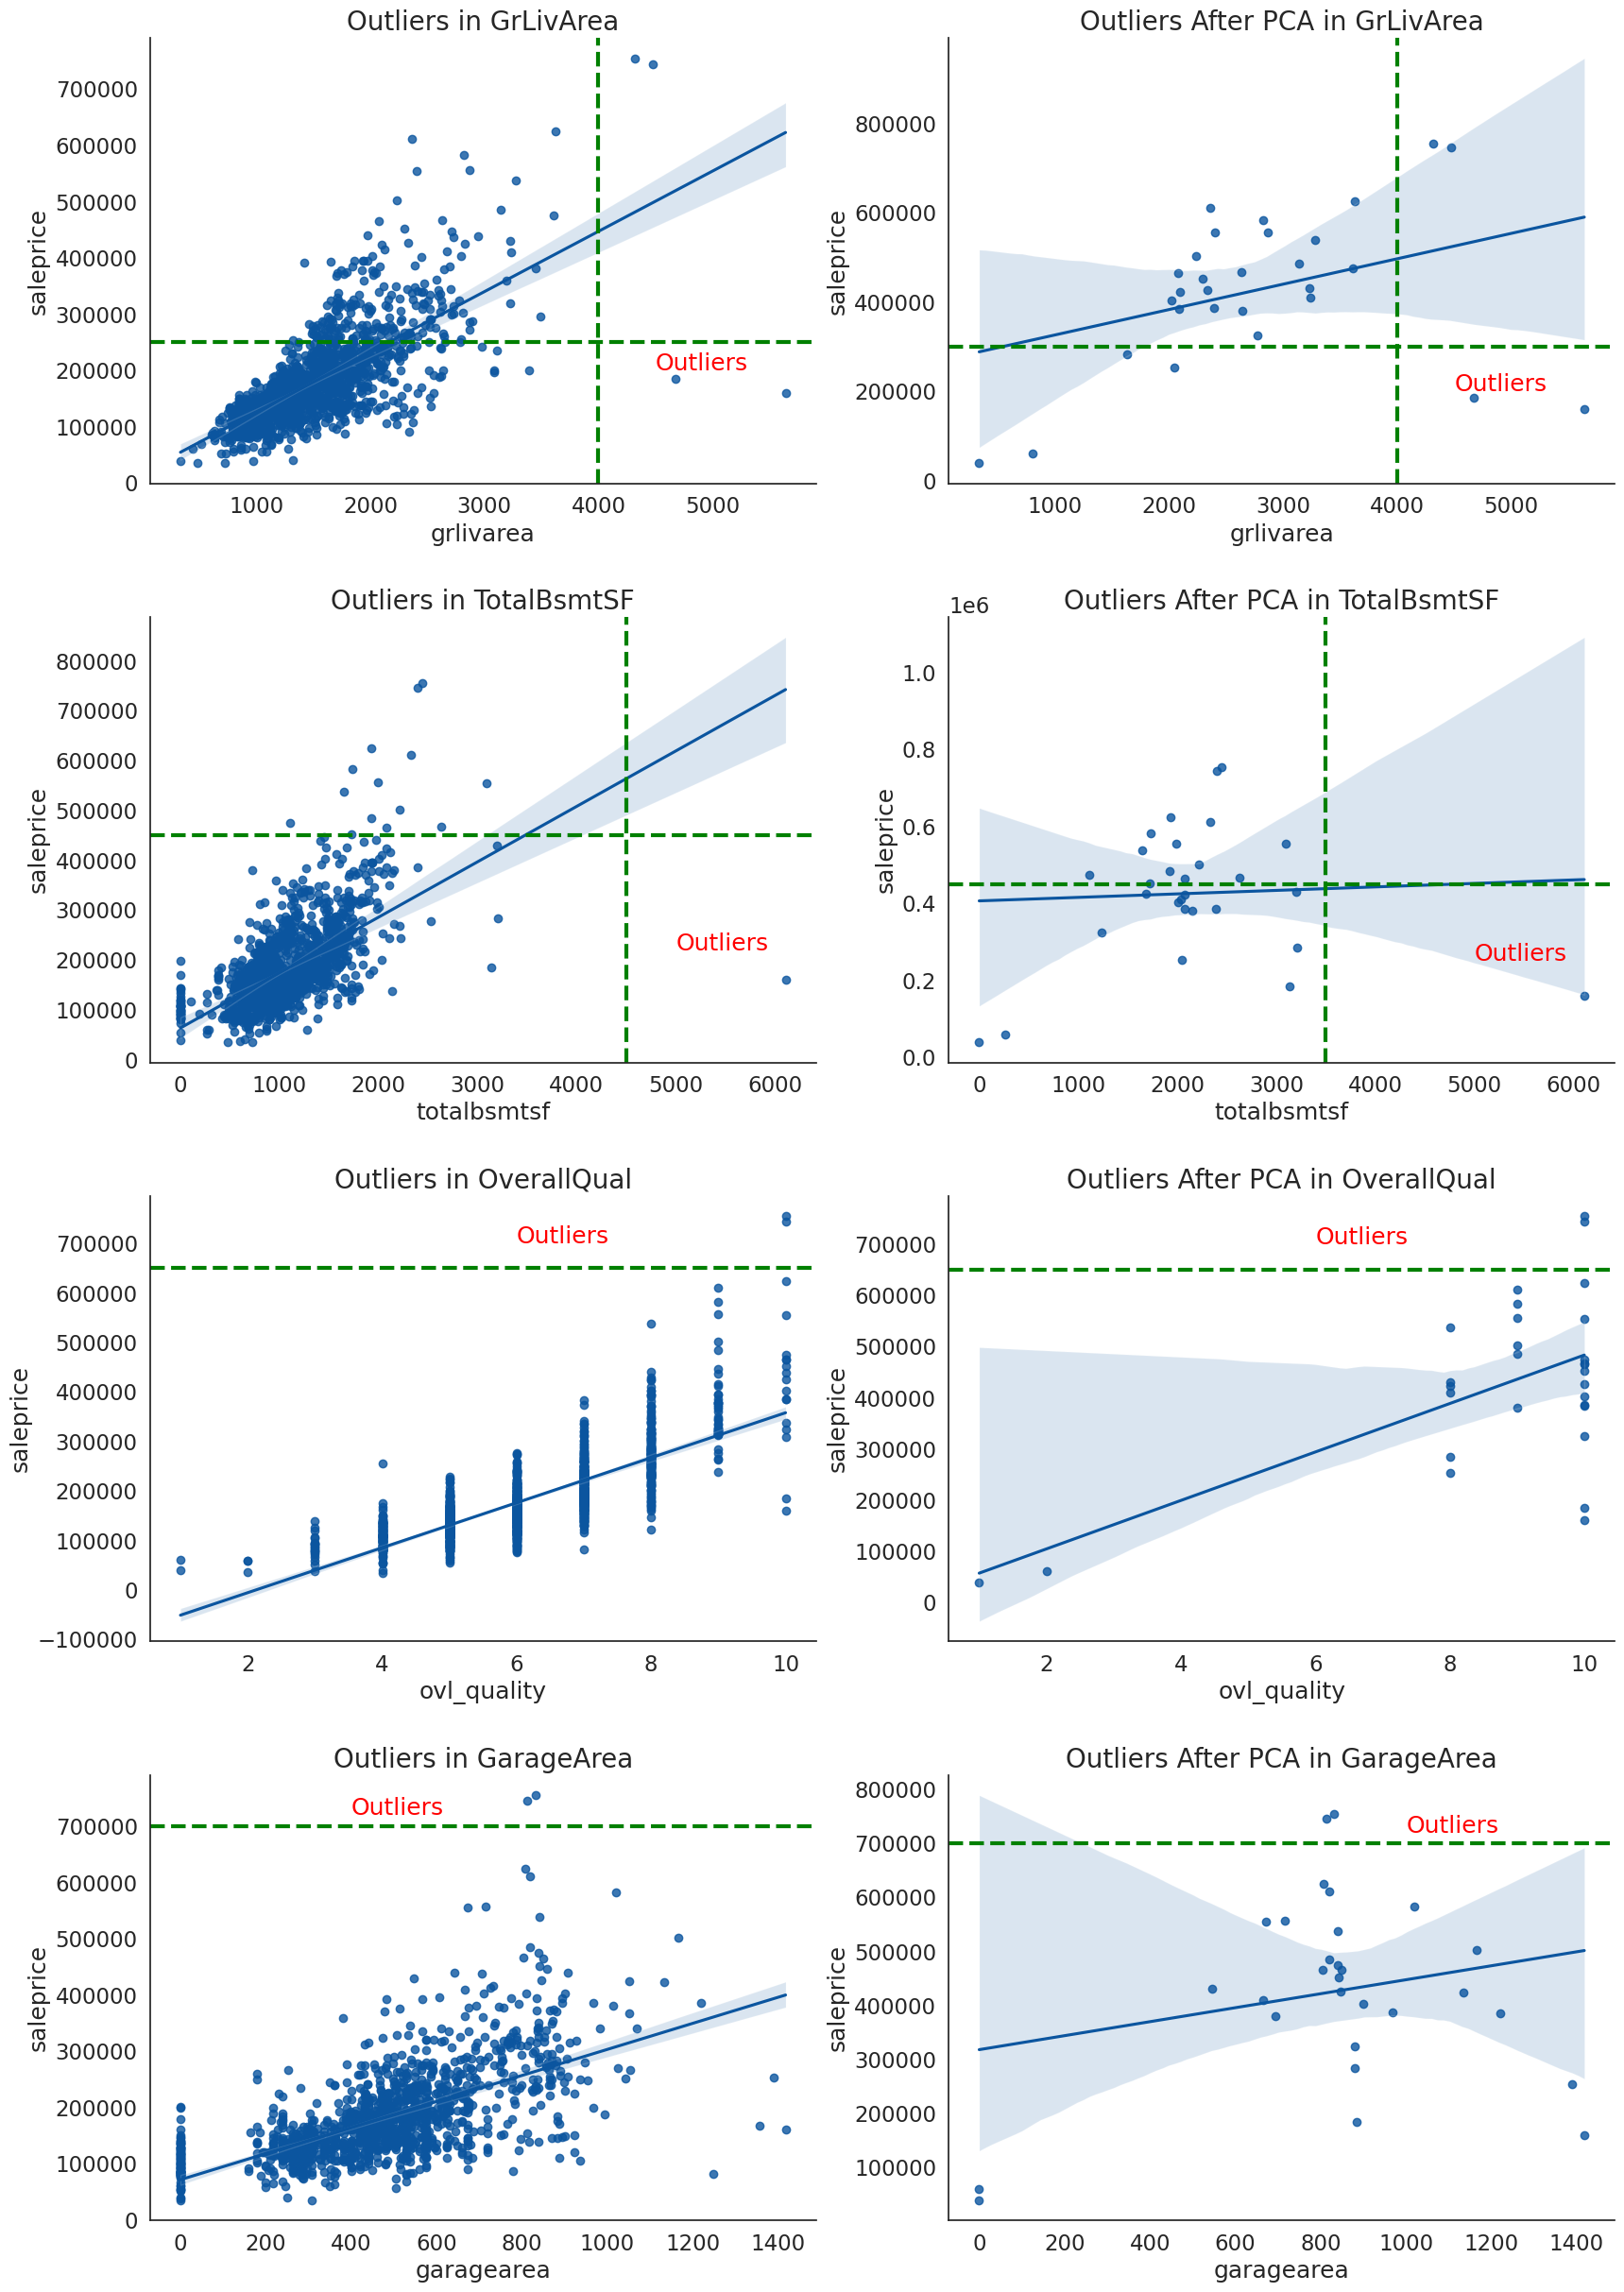

In [105]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.3)

# Plot for 'grlivarea'
plt.subplot(4, 2, 1)
ax1 = sns.regplot(data=data, x='grlivarea', y='saleprice')
ax1.set_title('Outliers in GrLivArea', fontsize=20)
# Customize these lines and text based on your data's specific outlier points
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 200000, 'Outliers', color='red')

plt.subplot(4, 2, 2)
ax2 = sns.regplot(data=data.iloc[pc1_outlier_idx, :], x='grlivarea', y='saleprice')
ax2.set_title('Outliers After PCA in GrLivArea', fontsize=20)
# Adjust these as needed
plt.axhline(y=300000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 200000, 'Outliers', color='red')

# Plot for 'totalbsmtsf'
plt.subplot(4, 2, 3)
ax3 = sns.regplot(data=data, x='totalbsmtsf', y='saleprice')
ax3.set_title('Outliers in TotalBsmtSF', fontsize=20)
# Customize these lines and text as necessary
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 220000, 'Outliers', color='red')

plt.subplot(4, 2, 4)
ax4 = sns.regplot(data=data.iloc[pc1_outlier_idx, :], x='totalbsmtsf', y='saleprice')
ax4.set_title('Outliers After PCA in TotalBsmtSF', fontsize=20)
# Adjust these as needed
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=3500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 250000, 'Outliers', color='red')

# Plot for 'ovl_quality'
plt.subplot(4, 2, 5)
ax5 = sns.regplot(data=data, x='ovl_quality', y='saleprice')
ax5.set_title('Outliers in OverallQual', fontsize=20)
# Customize these lines and text based on your data's specific outlier points
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(6, 700000, 'Outliers', color='red')

plt.subplot(4, 2, 6)
ax6 = sns.regplot(data=data.iloc[pc1_outlier_idx, :], x='ovl_quality', y='saleprice')
ax6.set_title('Outliers After PCA in OverallQual', fontsize=20)
# Adjust these as needed
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(6, 700000, 'Outliers', color='red')

# Plot for 'garagearea'
plt.subplot(4, 2, 7)
ax7 = sns.regplot(data=data, x='garagearea', y='saleprice')
ax7.set_title('Outliers in GarageArea', fontsize=20)
# Customize these lines and text as necessary
plt.axhline(y=700000, color='Green', linestyle='--', linewidth=3)
plt.text(400, 720000, 'Outliers', color='red')

plt.subplot(4, 2, 8)
ax8 = sns.regplot(data=data.iloc[pc1_outlier_idx, :], x='garagearea', y='saleprice')
ax8.set_title('Outliers After PCA in GarageArea', fontsize=20)
# Adjust these as needed
plt.axhline(y=700000, color='Green', linestyle='--', linewidth=3)
plt.text(1000, 720000, 'Outliers', color='red')

sns.despine()
plt.show()

**Looking at the figure above, points that are clearly judged as outliers in the figures on the left are also judged as outliers in PC1 after PCA. That is, outlier judgment using PCA seems very effective.**

**lets drop them**

In [106]:
data.drop(pc1_outlier_idx,axis=0,inplace=True,errors='ignore')
data.drop(pc2_outlier_idx,axis=0,inplace=True,errors='ignore')

**checking the graphs after removing outliers**

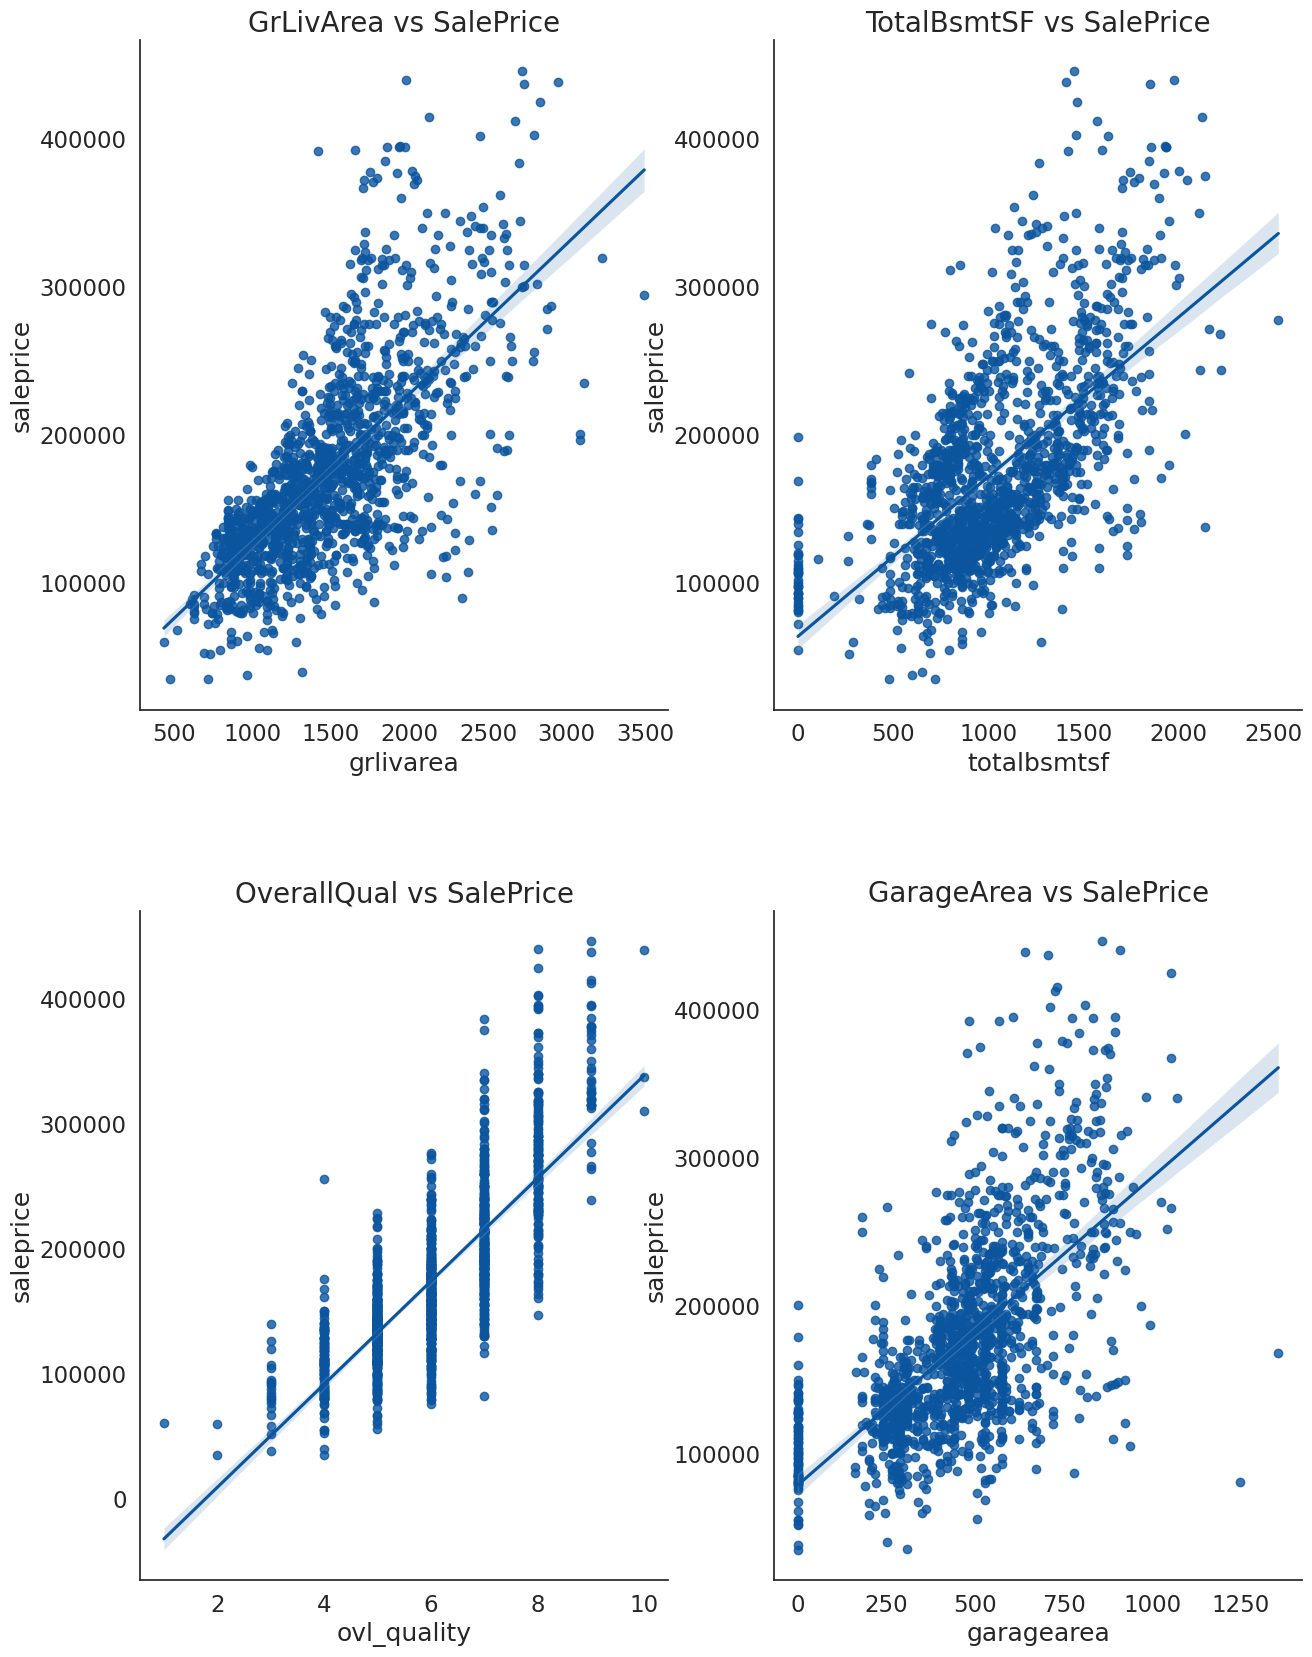

In [107]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)

# Plot for 'grlivarea'
plt.subplot(2, 2, 1)
ax1 = sns.regplot(data=data, x='grlivarea', y='saleprice')
ax1.set_title('GrLivArea vs SalePrice', fontsize=20)

# Plot for 'totalbsmtsf'
plt.subplot(2, 2, 2)
ax2 = sns.regplot(data=data, x='totalbsmtsf', y='saleprice')
ax2.set_title('TotalBsmtSF vs SalePrice', fontsize=20)

# Plot for 'ovl_quality'
plt.subplot(2, 2, 3)
ax3 = sns.regplot(data=data, x='ovl_quality', y='saleprice')
ax3.set_title('OverallQual vs SalePrice', fontsize=20)

# Plot for 'garagearea'
plt.subplot(2, 2, 4)
ax4 = sns.regplot(data=data, x='garagearea', y='saleprice')
ax4.set_title('GarageArea vs SalePrice', fontsize=20)

sns.despine()
plt.show()

**from the figures many points detected as outliers are removed**

# Adding new Derived features using Numerical features

**Let's create a new derived variable so that our model can learn better.**

**Subquestion Total Living Area and Its Impact on Sale Price: Does the total living area (sum of above-ground and basement areas) correlate strongly with the sale price? This can be explored by creating a new feature total_living_area = grlivarea+ttotalbsmtsf**

In [108]:
data["total_living_area"] = data.grlivarea + data.totalbsmtsf

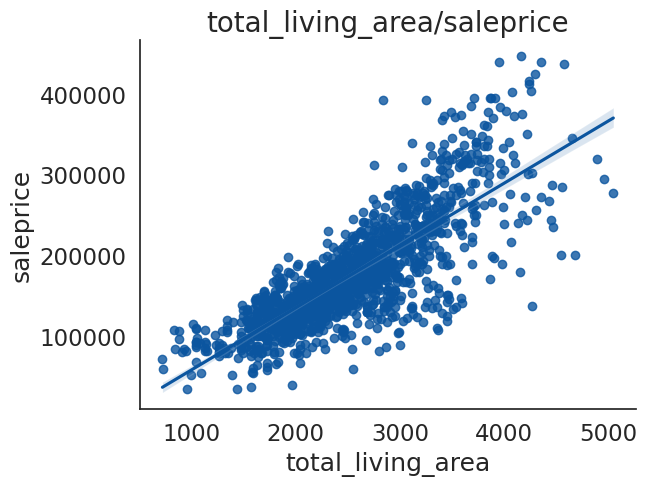

In [109]:
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=data, x='total_living_area',y='saleprice')
plt.title('total_living_area/saleprice',fontsize=20)
sns.despine()

**Subquestion : Garage Capacity and Area: Is there a combined effect of garage capacity and area on the sale price?**

In [110]:
data["GarageScore"] = data.garagecars * data.garagearea

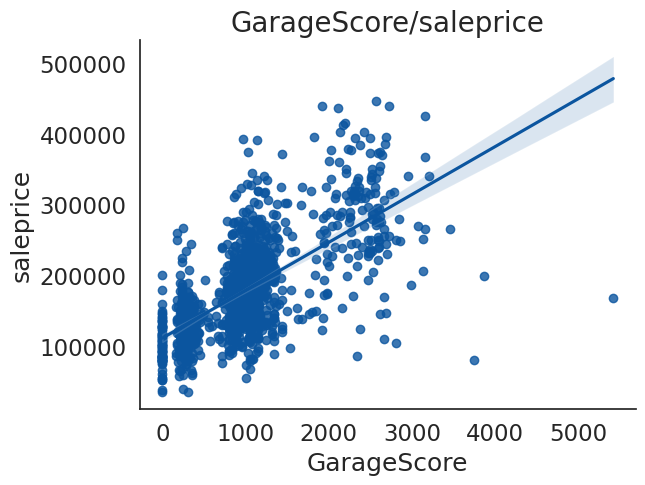

In [111]:
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=data, x='GarageScore',y='saleprice')
plt.title('GarageScore/saleprice',fontsize=20)
sns.despine()

**Can the combined area of the 1st and 2nd floors affect the sale price? 1stflrsf: First Floor square feet 2ndflrsf: Second floor square feet**

In [112]:
data["area_floors"] = data["1stflrsf"] + data["2ndflrsf"]

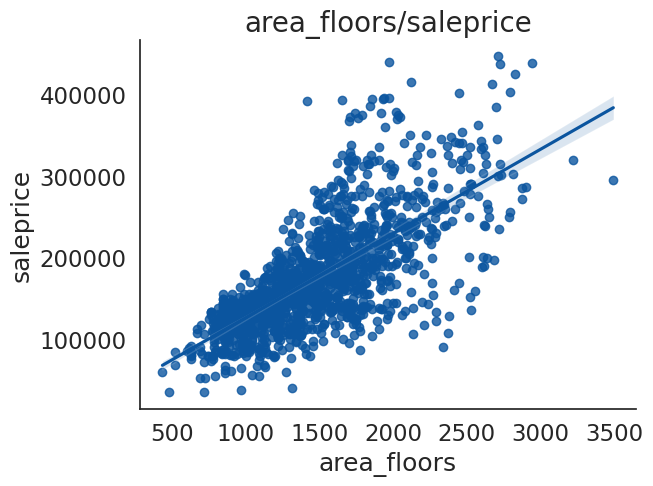

In [113]:
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=data, x='area_floors',y='saleprice')
plt.title('area_floors/saleprice',fontsize=20)
sns.despine()

*Good derivative features come from good questions. Good questions come from a lot of domain-knowledge*.

# Scaling Numerical features

**There are various scaling methods for numerical features. However, we will do  log scaling, which is a non-linear scaling of our target. Therefore, other numerical features are also subjected to log scaling.**

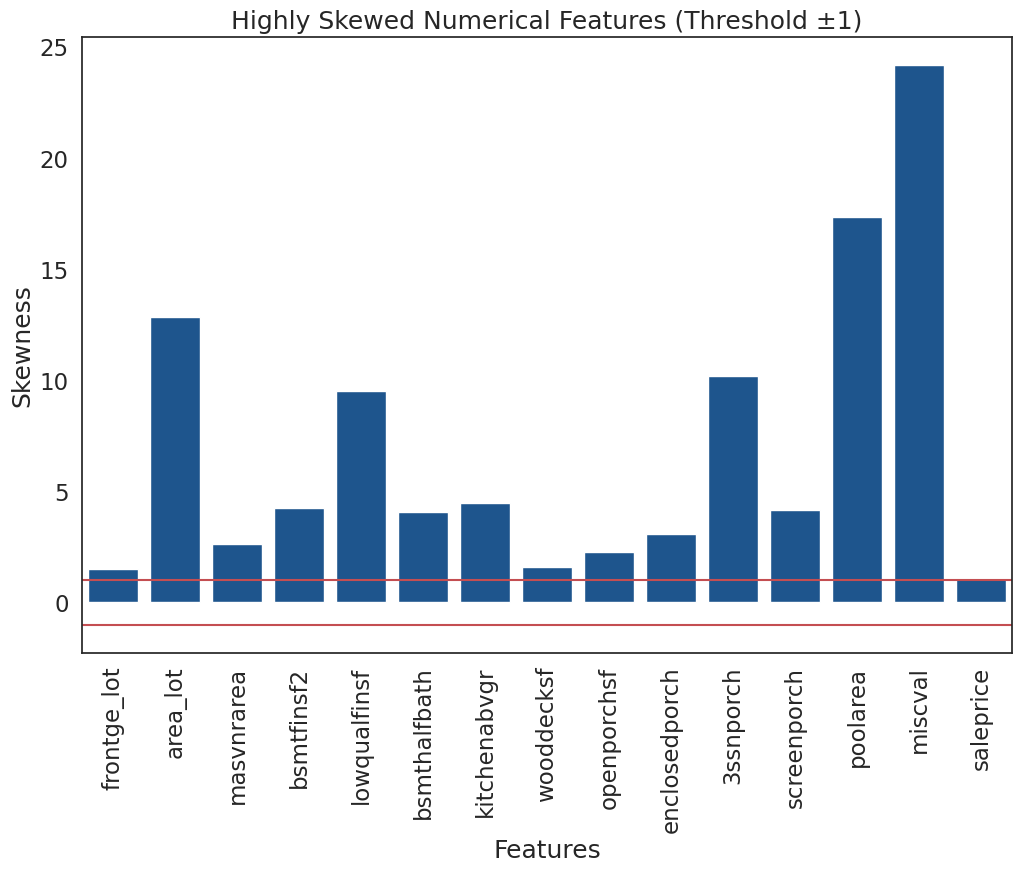

In [114]:
# Calculate skewness for each numerical feature
skewness_values = data[numerical_features].skew()

# Filter features with skewness greater than the threshold (absolute value)
threshold = 1
high_skewness = skewness_values[abs(skewness_values) > threshold]

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=high_skewness.index, y=high_skewness)
plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=-1, color='r', linestyle='-')
plt.xticks(rotation=90)
plt.title('Highly Skewed Numerical Features (Threshold ±1)')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.show()

**It is conformed that 15 features are skewed. We will do log transformation for these features.**

In [115]:
data[skewness_values.index] = np.log1p(data[skewness_values.index])

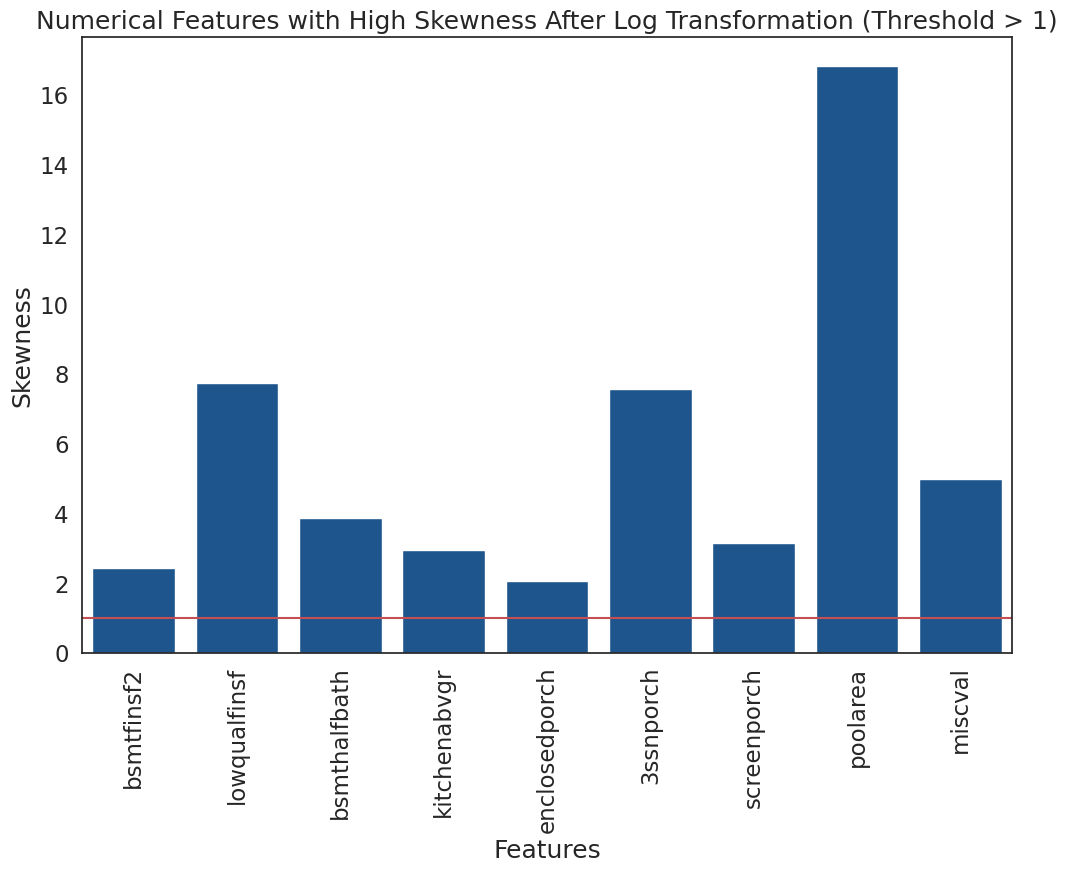

In [116]:
# Calculate skewness for each numerical feature after log transformation
skewness_values_after_log = data[numerical_features].apply(lambda x: np.log1p(x)).skew()

# Filter features with skewness greater than the threshold
threshold = 1
high_skewness_after_log = skewness_values_after_log[skewness_values_after_log > threshold]

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=high_skewness_after_log.index, y=high_skewness_after_log)
plt.axhline(y=threshold, color='r', linestyle='-')  # Line at the threshold
plt.xticks(rotation=90)
plt.title('Numerical Features with High Skewness After Log Transformation (Threshold > 1)')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.show()

**The number of skewed features is reduced from 15 to 9. The remaining 6 skewness was greatly reduced.**

# EDA For Categorical Features

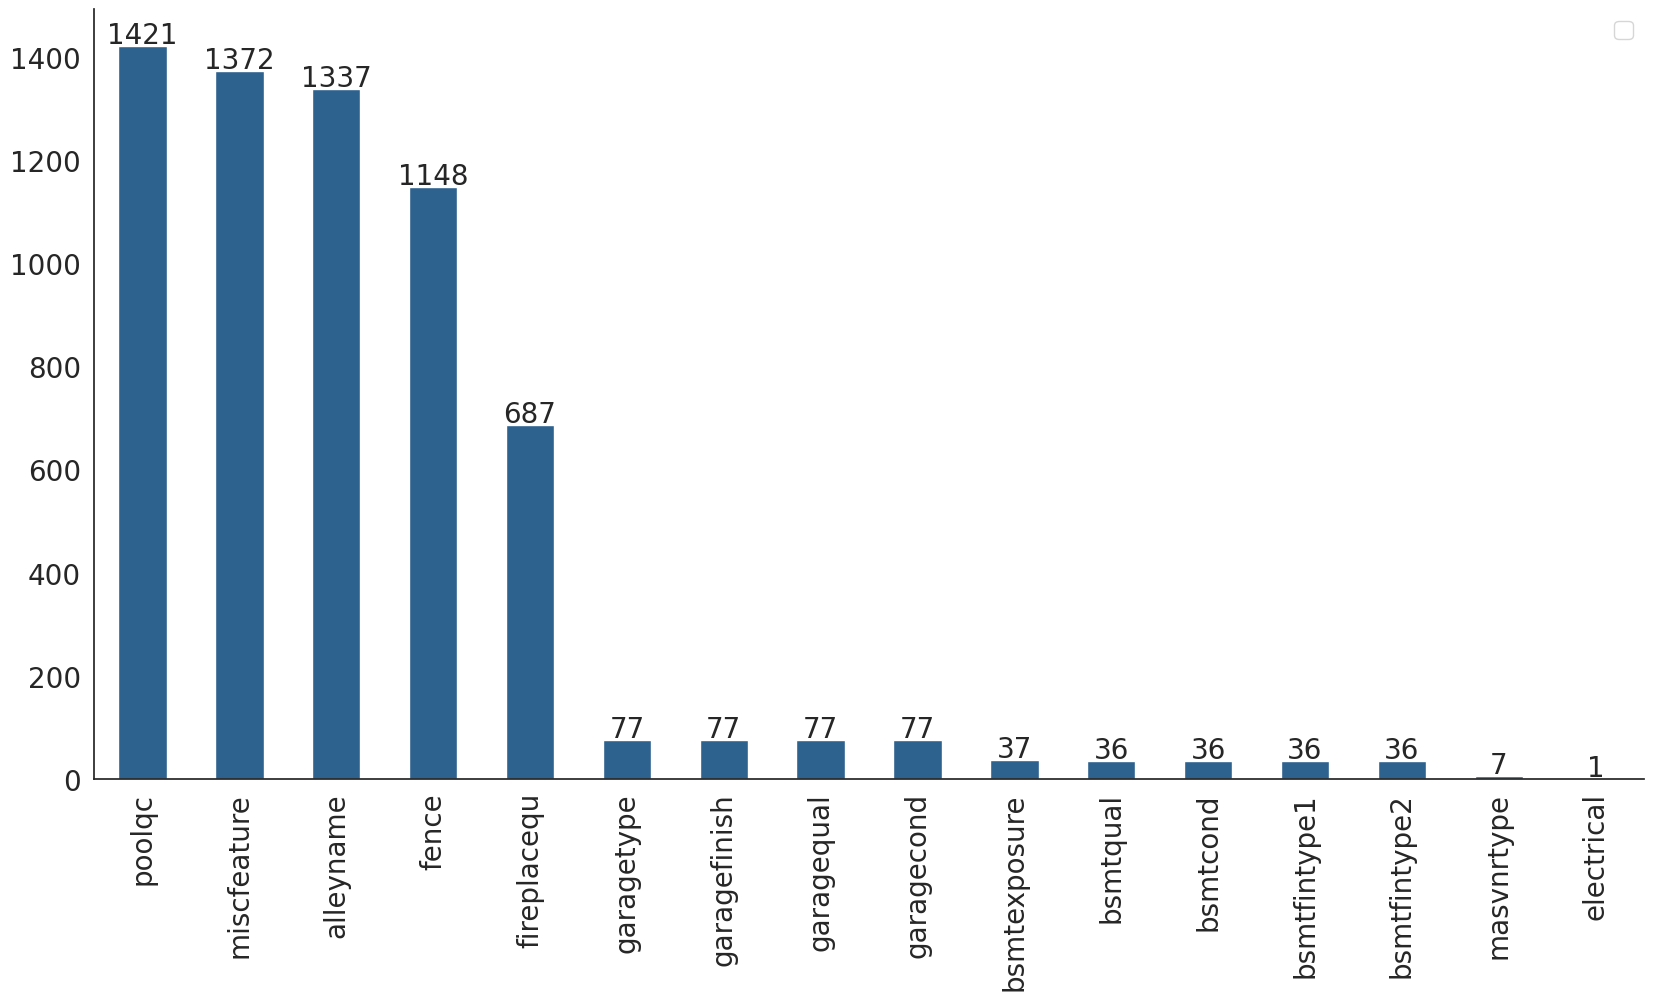

In [117]:
isnull_series = data.loc[:,:'salecondition'].isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

plt.figure(figsize = (20,10))
ax = isnull_series[isnull_series > 0].sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='#2d618e'
                                                                        )
plt.legend(loc = 'upper right')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 5, height, ha = 'center', size = 20)
sns.despine()

**poolqc, miscfeature, alley, fence, and fireplacequ features have too many missing values. Deleting those features may be the optimal way.**

**Garage-related features have 77 missing values. It is unknown whether the houses lacked garages or were intentionally omitted. Basement-related features also have 36 to 37 missing values. It seems that we need to focus more on the process of filling in the missing values ​​of the corresponding Garage and Basement features.**

In [118]:
columns_to_drop = ['poolqc', 'miscfeature', 'alleyname', 'fence','electrical', 'fireplacequ']
data = data.drop(columns=columns_to_drop)

**Garage Features
Question: Is there a difference in house price with and without Garage?**



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='garagecond', ylabel='saleprice'>

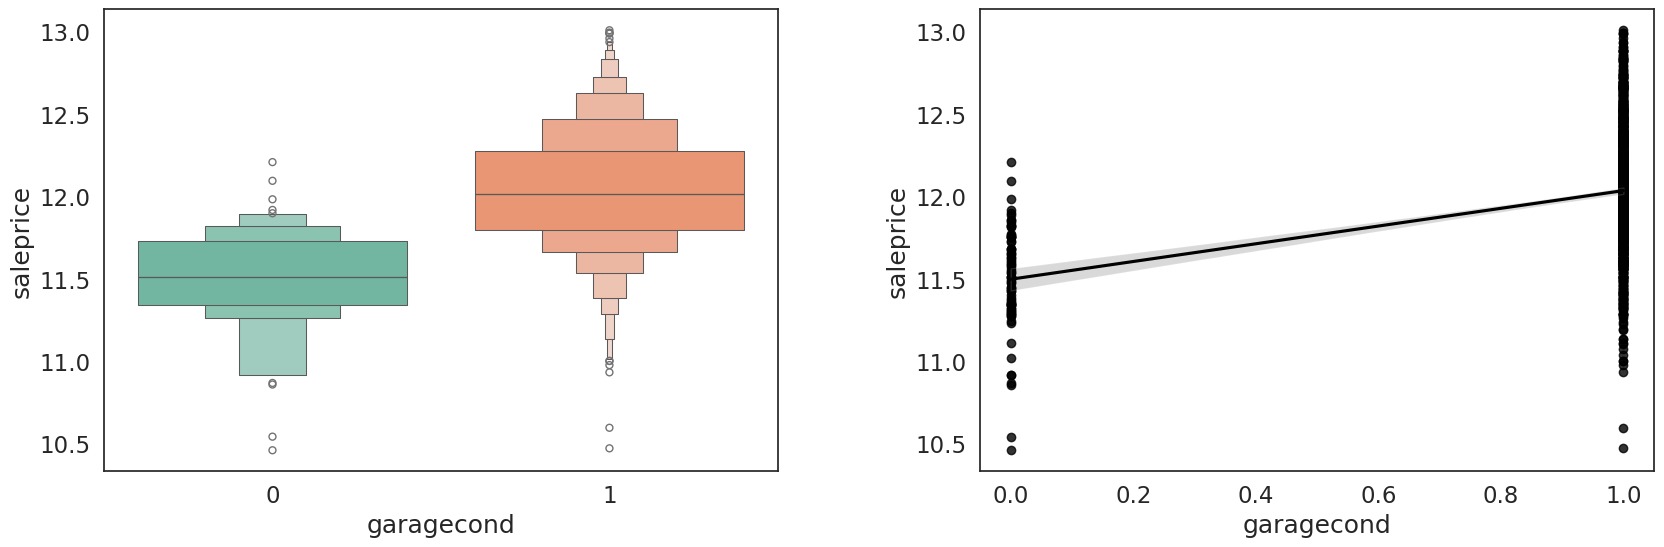

In [119]:
data['garagecond'] = data['garagecond'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=data, x='garagecond',y='saleprice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=data, x='garagecond',y='saleprice',color='black')

**Basement features Question: Is there a difference in the house price with and without a Basement?**



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='bsmtcond', ylabel='saleprice'>

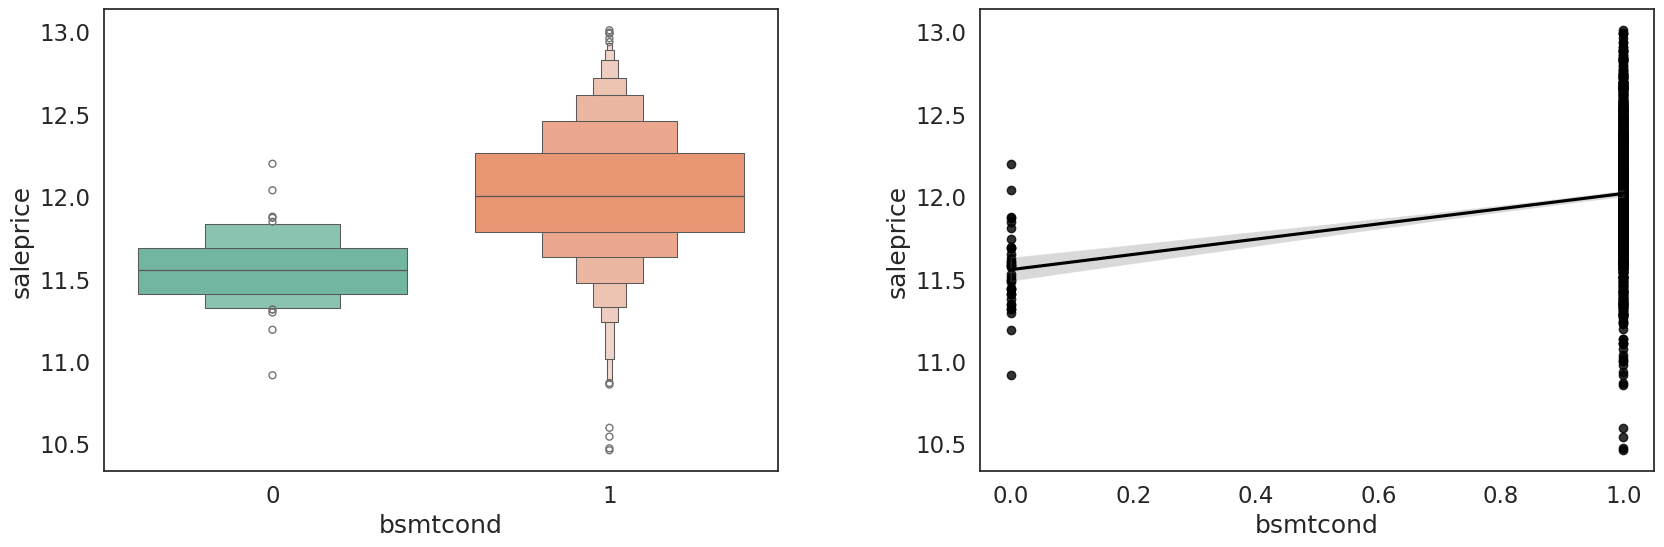

In [120]:
data['bsmtcond'] = data['bsmtcond'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=data, x='bsmtcond',y='saleprice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=data, x='bsmtcond',y='saleprice',color='black')

**masvnrtype: Masonry veneer type Question: Is there a difference in house price with and without Masonry veneer?**



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='masvnrtype', ylabel='saleprice'>

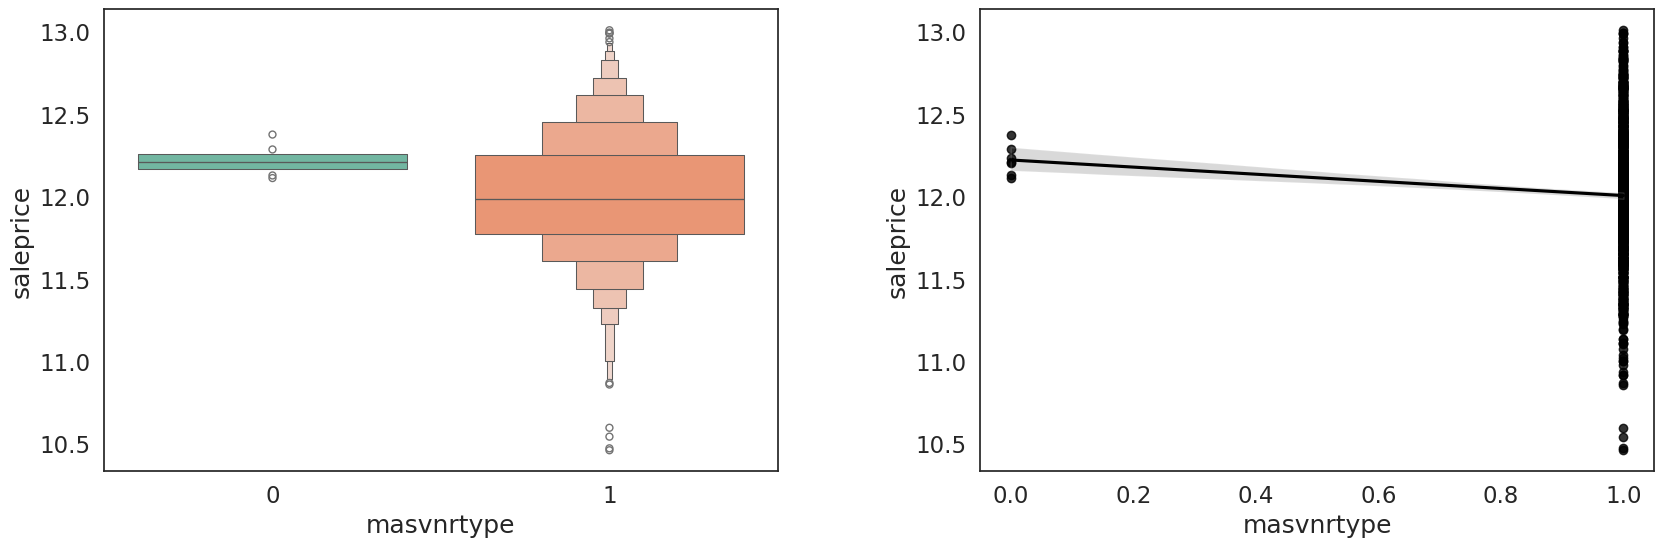

In [121]:
data['masvnrtype'] = data['masvnrtype'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=data, x='masvnrtype',y='saleprice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=data, x='masvnrtype',y='saleprice',color='black')

**its seems that there is a relation between them so i'll have to fill their missing values**

In [122]:
data['garagetype'] = data['garagetype'].fillna('missing')
data['garagefinish'] = data['garagefinish'].fillna(data['garagefinish'].mode()[0])
data['garagequal'] = data['garagequal'].fillna(data['garagequal'].mode()[0])
data['garagecond'] = data['garagecond'].fillna('missing')
data['bsmtexposure'] = data['bsmtexposure'].fillna(data['bsmtexposure'].mode()[0])
data['bsmtqual'] = data['bsmtqual'].fillna(data['bsmtqual'].mode()[0])
data['bsmtcond'] = data['bsmtcond'].fillna(data['bsmtcond'].mode()[0])
data['bsmtfintype1'] = data['bsmtfintype1'].fillna('missing')
data['bsmtfintype2'] = data['bsmtfintype2'].fillna('missing')
data['masvnrtype'] = data['masvnrtype'].fillna('None')

In [123]:
missing_values = data.isnull().sum()

# Print the features with missing values
print("Features with missing values:")
print(missing_values[missing_values > 0])

Features with missing values:
Series([], dtype: int64)


**Great now thats handled let's move on to Ordinal features**

# Ordinal features

**Checking Ordinal Features In some cases, it is easy to judge that there is an order on a commonsense level. However, there are many cases where it is difficult to judge that there is an order. The method i used in this notebook to determine whether the features are ordinal or not was determined by having a certain order through visualization then doing research on every features so i can order them**

In [124]:
# Print the unique values
print("Unique values of the feature:")
print(data['zoning_ms'].unique())

Unique values of the feature:
['RM' 'RL' 'FV' 'C (all)' 'RH']


Identifies the general zoning classification of the sale.

RM: Residential Medium Density

RL: Residential Low Density

FV: Floating Village Residential

C (all ): Commercial

RH: Residential High Density



In [125]:
data['zoning_ms'] = data['zoning_ms'].replace({'C (all)':1,'RM':2,'RH':3,'RL':4,'FV':5})

In [126]:
# Print the unique values
print("Unique values of the feature:")
print(data['style_house'].unique())

Unique values of the feature:
['1.5Unf' '1Story' '2Story' '1.5Fin' '2.5Unf' 'SLvl' 'SFoyer' '2.5Fin']


HouseStyle: Style of dwelling

1.5Unf: One and one-half story: 2nd level unfinished

1Story: One story

2Story: Two story

1.5Fin: One and one-half story: 2nd level finished

2.5Unf: Two and one-half story: 2nd level unfinished

SLvl: Split Level

SFoyer: Split Foyer

2.5Fin: Two and one-half story: 2nd level finished

In [127]:
data['style_house'] = data['style_house'].replace({
    '1.5Unf': 0,
    'SFoyer': 1,
    '1.5Fin': 2,
    '2.5Unf': 3,
    'SLvl': 4,
    '1Story': 5,
    '2Story': 6,
    '2.5Fin': 7
})

In [128]:
# Print the unique values
print("Unique values of the feature:")
print(data['garagefinish'].unique())

Unique values of the feature:
['Unf' 'Fin' 'RFn']


In [129]:
data['garagefinish'] = data['garagefinish'].replace({'Unf':1,'RFn':2,'Fin':3})

In [130]:
# Print the unique values
print("Unique values of the feature:")
print(data['bsmtqual'].unique())

Unique values of the feature:
['TA' 'Ex' 'Gd' 'Fa']


Basement Quality

TA Average/Typical

Ex Excellent

Gd Good

Fa Fair

In [131]:
data['bsmtqual'] = data['bsmtqual'].replace({'Fa':1,'TA':2,'Gd':3,'Ex':4})

**Great lets move to the next step since ordinal ones are out of the way, Pheew!**

# Final look on our data before modeling

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


Text(0.5, 1.0, 'Correlation with saleprice')

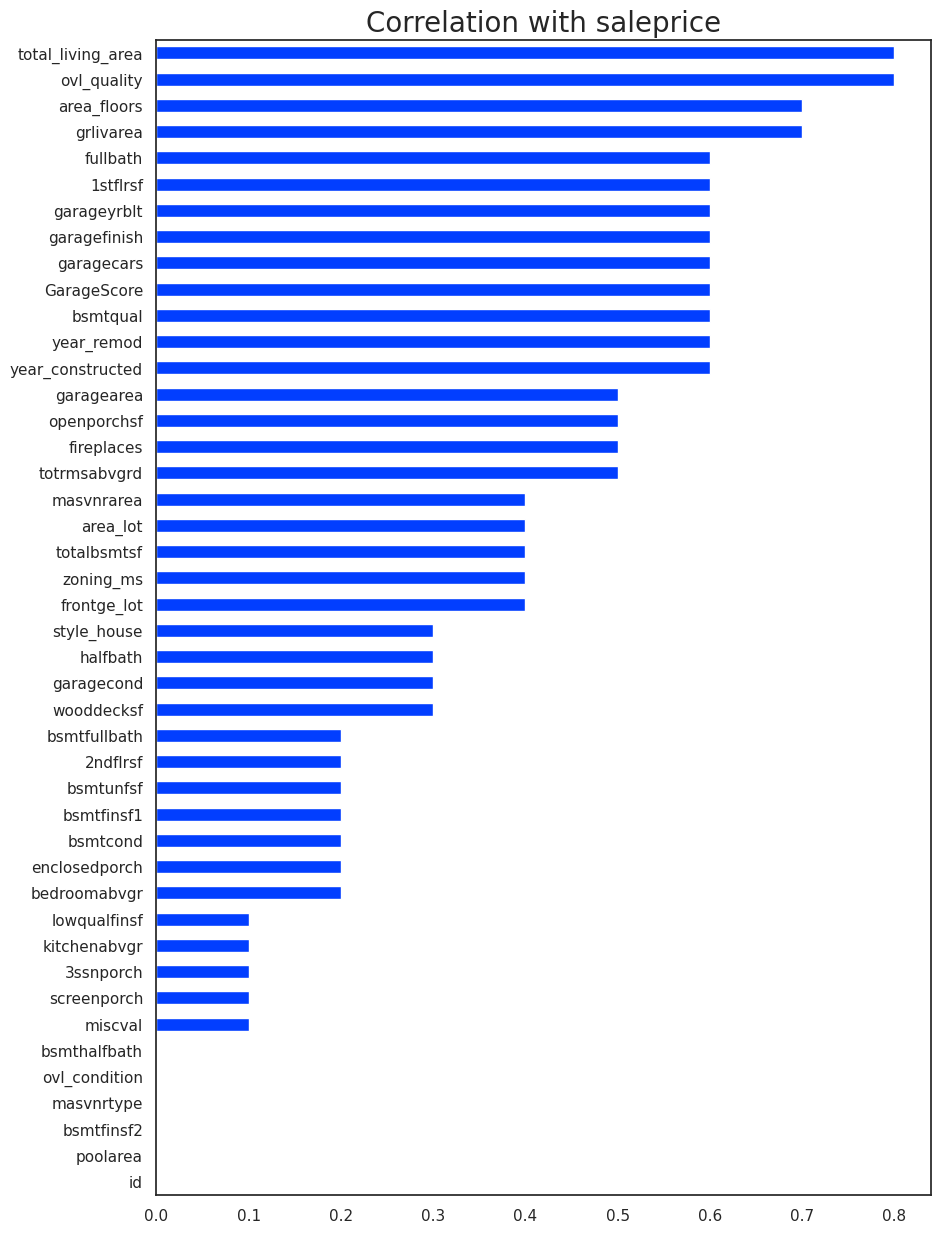

In [132]:
corr=data.corr().round(1)
sns.set(font_scale=1)
plt.figure(figsize=(10, 15))
sns.set_style("white")
sns.set_palette("bright")
abs(corr['saleprice']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')
plt.title('Correlation with saleprice',fontsize=20)

**The newly created derivative variable total_living_area feature and garagescore have a high correlation!
Pool-related features and fireplaces with many missing values have a low correlation with house price.**

**lets remove features that have a correlation of 0**

In [133]:
abs_corr = abs(corr['saleprice']).sort_values()[:-1]
low_corr_list = abs_corr[abs_corr.values == 0].index
data.drop(low_corr_list, axis=1,inplace=True)

**lets remove also the features that have 0.25 lower threshhold**

In [134]:
corr_matrix = data.corr()

# Get the absolute correlation with 'saleprice'
saleprice_corr = corr_matrix['saleprice'].abs()

# Identify columns with correlation less than 0.25
low_corr_cols = saleprice_corr[saleprice_corr < 0.25].index

# Drop these columns from the DataFrame
data.drop(columns=low_corr_cols, inplace=True)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


**Baam! now for Modeling**

# Modeling

**encoding nominal data using one-hot encoding**

In [135]:
data = pd.get_dummies(data)

**Now lets split our data to train and test and sxale our target as said earlier**

In [136]:
X = data.drop('saleprice', axis=1)  # Features
y = data['saleprice']               # Target variable

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ***Regression***

In [138]:
pip install pycaret

In [139]:
pip install catboost xgboost lightgbm scikit-learn

**as for my regression model i chose to work with catboost , adaboost , xgboost and lightgbm**

In [140]:
# Define create_model function for CatBoost
def create_catboost(X_train, y_train):
    model = cb.CatBoostRegressor()
    model.fit(X_train, y_train)
    return model

# Define create_model function for AdaBoost
def create_adaboost(X_train, y_train):
    model = AdaBoostRegressor()
    model.fit(X_train, y_train)
    return model

# Define create_model function for XGBoost
def create_xgboost(X_train, y_train):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    return model

# Define create_model function for LightGBM
def create_lightgbm(X_train, y_train):
    model = lgb.LGBMRegressor()
    model.fit(X_train, y_train)
    return model

In [141]:
catboost_model = create_catboost(X_train, y_train)
adaboost_model = create_adaboost(X_train, y_train)
xgboost_model = create_xgboost(X_train, y_train)
lightgbm_model = create_lightgbm(X_train, y_train)

Learning rate set to 0.041799
0:	learn: 0.3580229	total: 20.2ms	remaining: 20.2s
1:	learn: 0.3484807	total: 38ms	remaining: 19s
2:	learn: 0.3389092	total: 54.6ms	remaining: 18.1s
3:	learn: 0.3299765	total: 70.8ms	remaining: 17.6s
4:	learn: 0.3211832	total: 95.9ms	remaining: 19.1s
5:	learn: 0.3128586	total: 111ms	remaining: 18.5s
6:	learn: 0.3052453	total: 144ms	remaining: 20.4s
7:	learn: 0.2974191	total: 161ms	remaining: 19.9s
8:	learn: 0.2897735	total: 177ms	remaining: 19.4s
9:	learn: 0.2832295	total: 195ms	remaining: 19.4s
10:	learn: 0.2761470	total: 231ms	remaining: 20.7s
11:	learn: 0.2694958	total: 247ms	remaining: 20.4s
12:	learn: 0.2634982	total: 263ms	remaining: 20s
13:	learn: 0.2574357	total: 275ms	remaining: 19.4s
14:	learn: 0.2516482	total: 292ms	remaining: 19.2s
15:	learn: 0.2459561	total: 319ms	remaining: 19.6s
16:	learn: 0.2404965	total: 353ms	remaining: 20.4s
17:	learn: 0.2358900	total: 383ms	remaining: 20.9s
18:	learn: 0.2310040	total: 437ms	remaining: 22.6s
19:	learn: 0

**lets compare their metrics**

In [142]:
# Function to compute MAPE - Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate metrics
def calculate_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    return mae, mse, rmse, r2, mape

# Compute metrics for each model
catboost_metrics = calculate_metrics(catboost_model, X_test, y_test)
adaboost_metrics = calculate_metrics(adaboost_model, X_test, y_test)
xgboost_metrics = calculate_metrics(xgboost_model, X_test, y_test)
lightgbm_metrics = calculate_metrics(lightgbm_model, X_test, y_test)

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame([catboost_metrics, adaboost_metrics, xgboost_metrics, lightgbm_metrics],
                          columns=['MAE', 'MSE', 'RMSE', 'R2', 'MAPE'],
                          index=['CatBoost', 'AdaBoost', 'XGBoost', 'LightGBM'])

metrics_df

MAE       MSE      RMSE        R2      MAPE
CatBoost  0.090722  0.018785  0.137060  0.881314  0.766496
AdaBoost  0.137178  0.033543  0.183148  0.788075  1.150675
XGBoost   0.107428  0.023911  0.154631  0.848932  0.906013
LightGBM  0.101490  0.022509  0.150030  0.857788  0.856067

**Interpret the models using shap**

In [143]:
pip install shap


**Test on testing data**

In [144]:
X_test_scaled = scaler.transform(X_test)
catboost_predictions = catboost_model.predict(X_test_scaled)

# Step 3: Evaluate the CatBoost Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(predictions, actual):
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = mean_squared_error(actual, predictions, squared=False)
    r2 = r2_score(actual, predictions)
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

print("CatBoost Model Evaluation:")
evaluate_model(catboost_predictions, y_test)

CatBoost Model Evaluation:
MAE: 1.0124146687687643, MSE: 1.11433281553188, RMSE: 1.0556196358214827, R²: -6.0403511347138865


X does not have valid feature names, but StandardScaler was fitted with feature names


## **CLUSTERING**

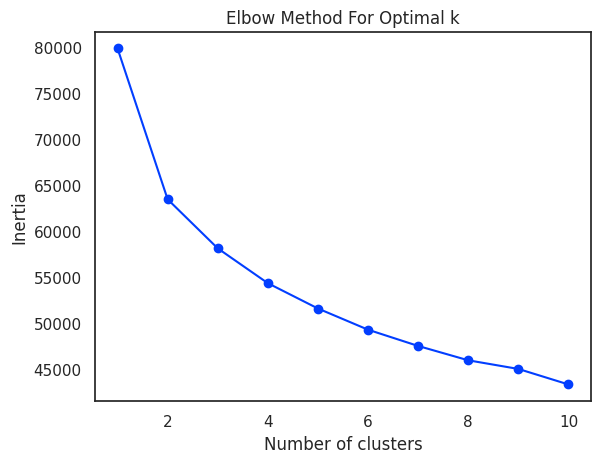

In [ ]:
k_range = range(1, 11)

inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Let's say optimal number of clusters is found to be 5
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
data['Cluster'] = clusters


In [ ]:
from sklearn.preprocessing import Normalizer

# Dropping 'SalePrice' for clustering
X = data.drop('saleprice', axis=1)

# Normalizing data
nrm = Normalizer()
nrm.fit(X)
normal_data = nrm.transform(X)

In [ ]:
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import ward, fcluster, dendrogram


In [ ]:
link = ward(res_tsne)

# Define a threshold distance to determine the number of clusters
threshold = 300
vb = fcluster(link, t=threshold, criterion='distance')

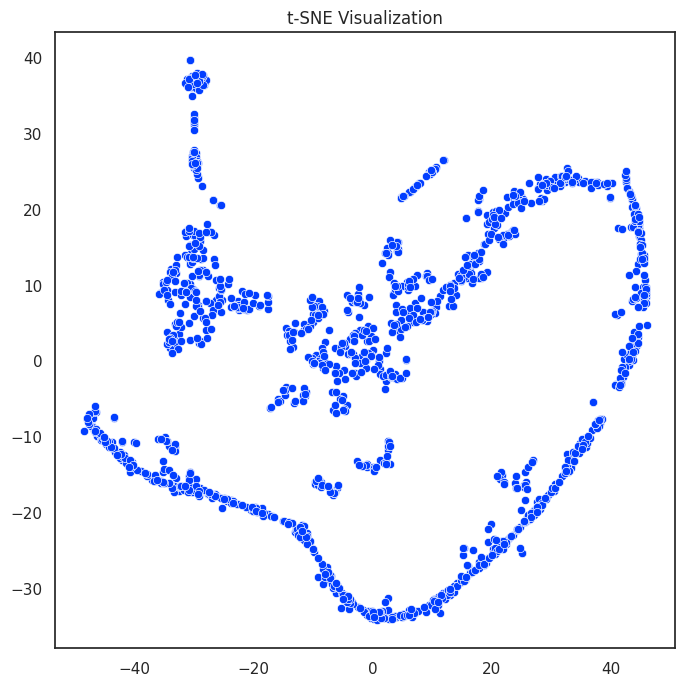

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=res_tsne[:,0], y=res_tsne[:,1])
plt.title("t-SNE Visualization")
plt.show()

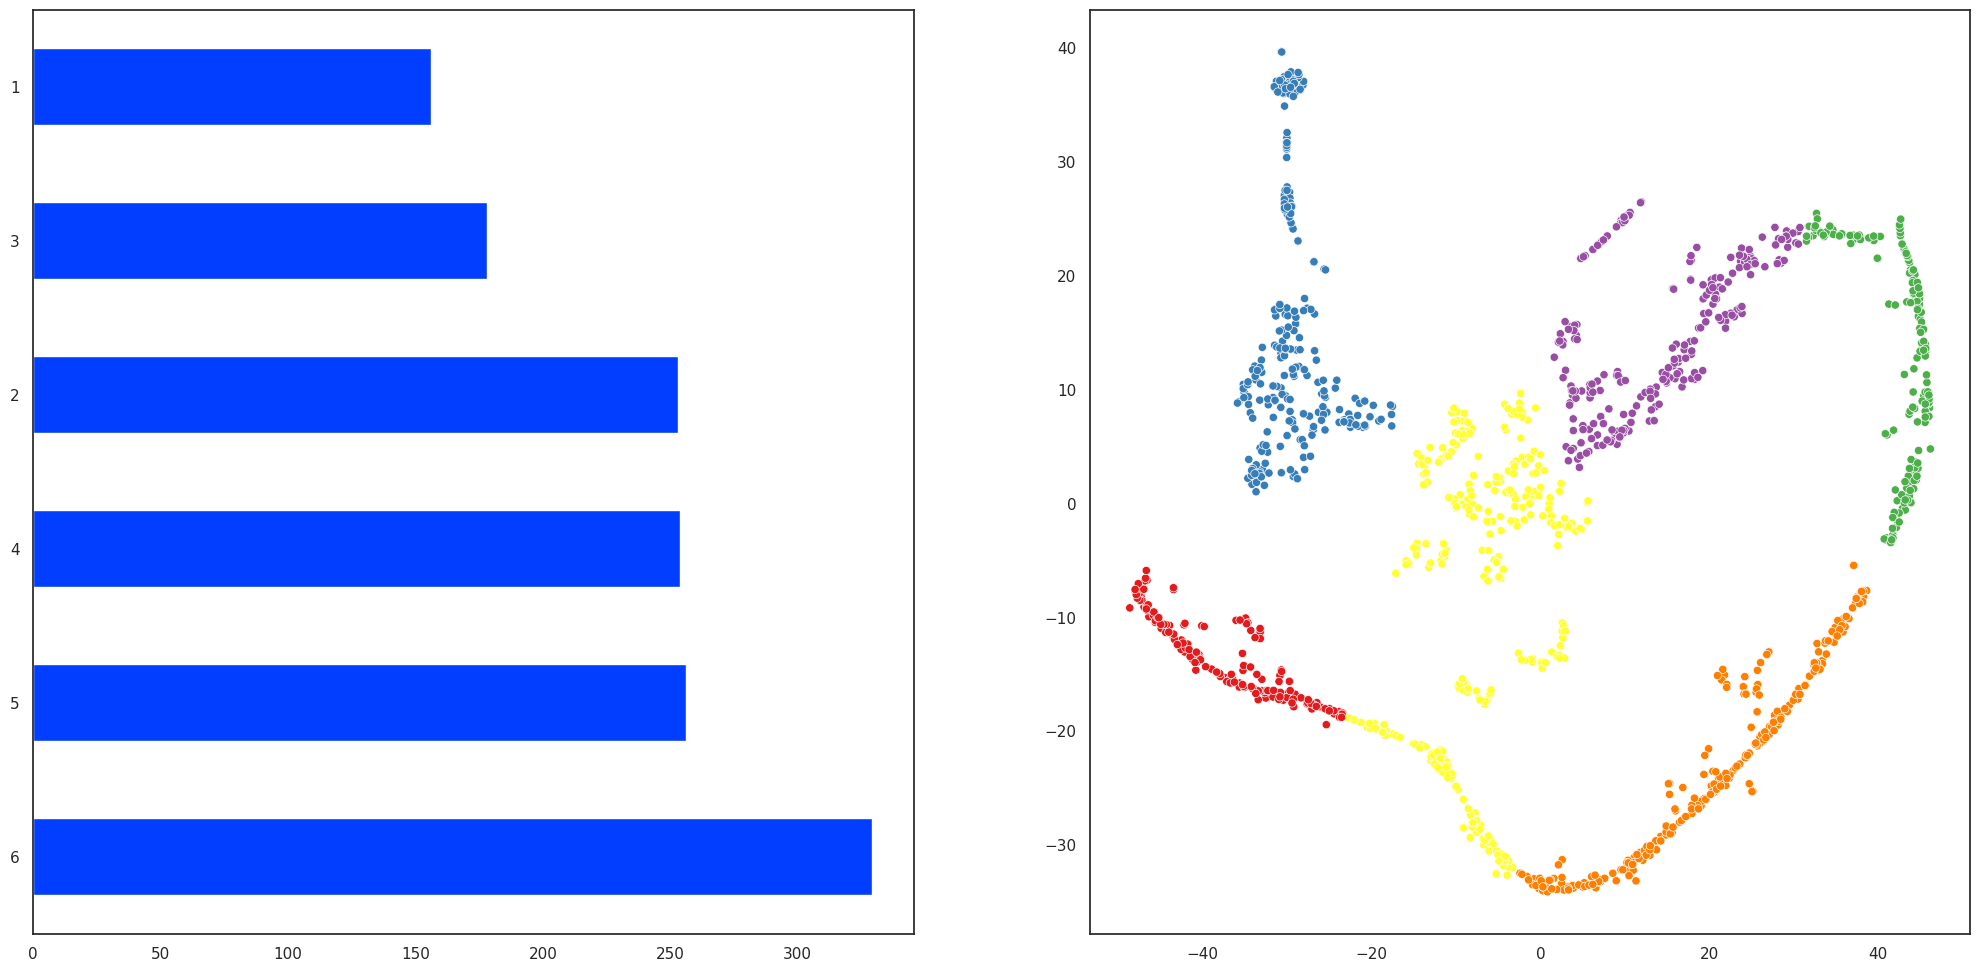

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 12))
pd.value_counts(vb).plot(kind='barh', ax=ax[0])
sns.scatterplot(x=res_tsne[:,0], y=res_tsne[:,1], hue=vb, palette="Set1", ax=ax[1])
ax[1].legend_.remove()
plt.show()

The graph show price distribution across 6 clusters.

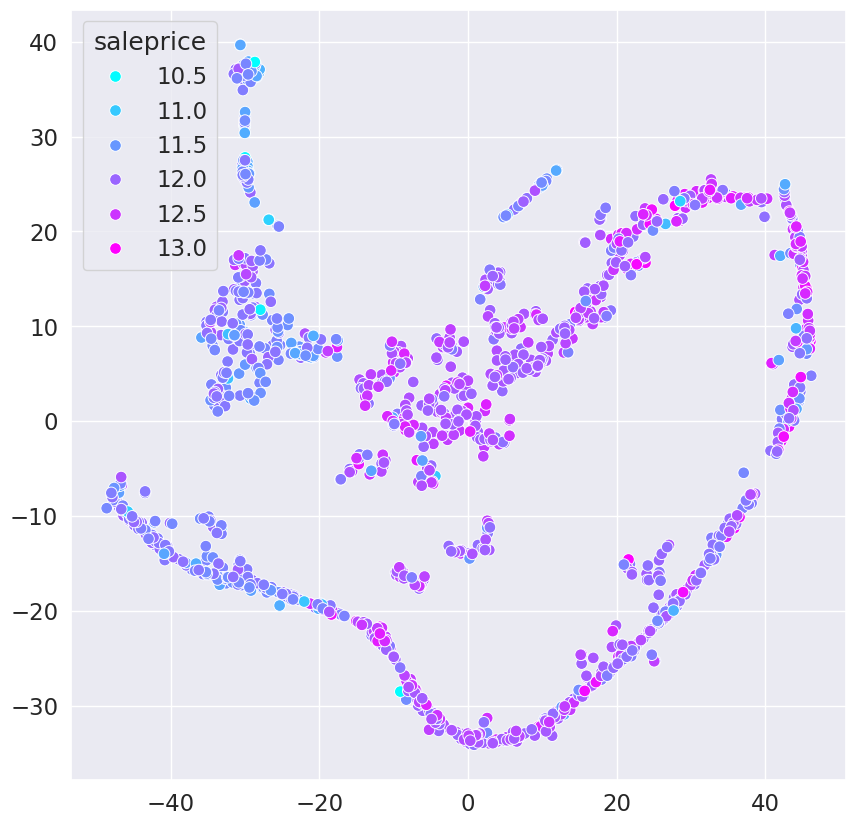

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],\
                     hue=data['saleprice'],s=70,palette="cool");#,palette="RdBu");

Then I choose most import features (by correlation coefficients):
OverallQual, GrLivArea, 1stFlrSF, FullBath.

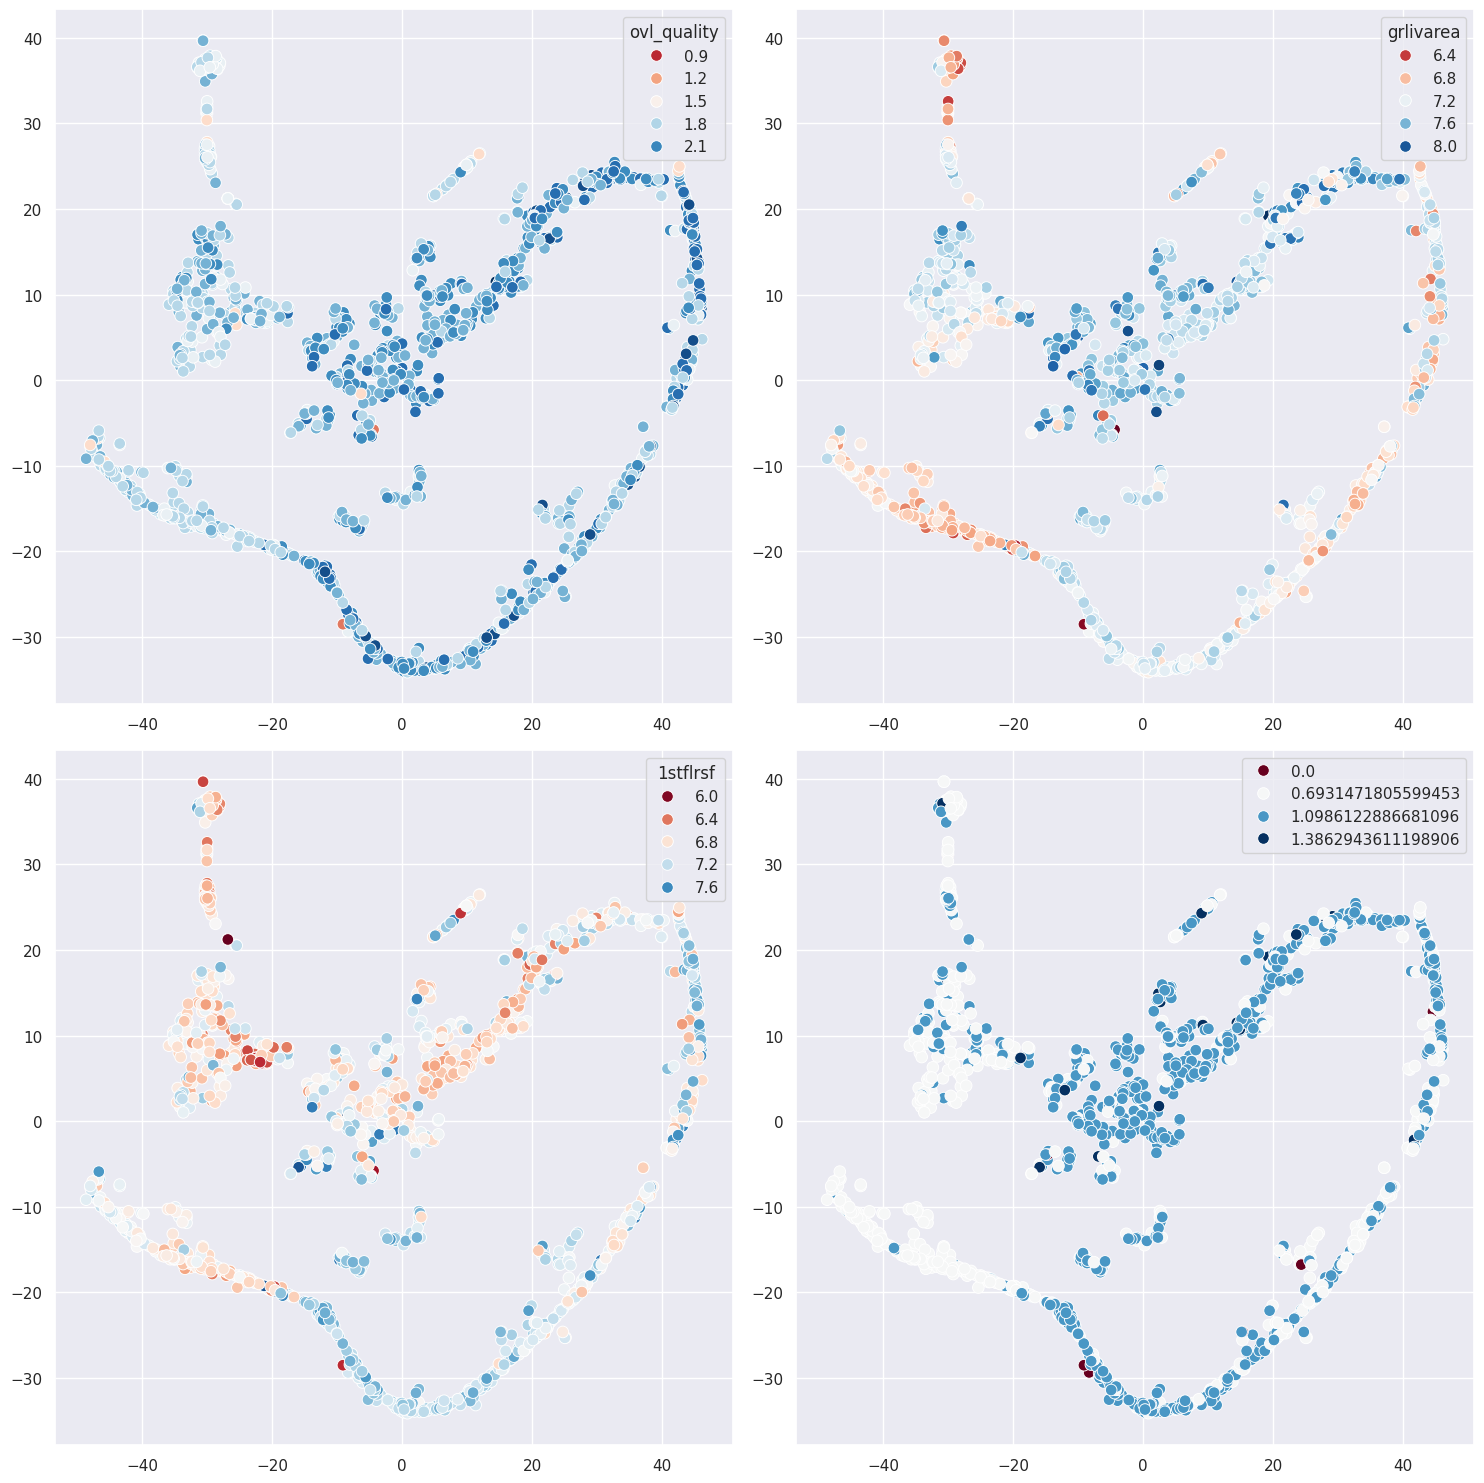

In [ ]:
most_sign = ['ovl_quality','grlivarea','1stflrsf','fullbath']
n_row, n_col = 2, 2
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(15,15))
sns.set(font_scale=1)
sns.axes_style("whitegrid")
for i in enumerate(most_sign):
    qq = sns.scatterplot(
        x=res_tsne[:,0], y=res_tsne[:,1], ax=axes[i[0]//n_row,i[0]%n_col],
        hue=data[i[1]], s=70, palette="RdBu"
    );
plt.legend().set_title('')
plt.tight_layout()